In [215]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, confusion_matrix
from sklearn import tree
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt


import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
import requests
import graphviz
import json
import csv
import io

# Constants
CASES_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
DEATHS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv'
POPS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv'

## Get Data, Preprocessing

In [3]:
# get_dataframes -> (DataFrame, DataFrame, DataFrame)
# reads the cases, deaths, and populations json files in and converts them to pandas dataframes.
def get_dataframes():
    cases_df = ''
    deaths_df = ''
    pops_df = ''

    with open('cases.json') as file:
        cases_data = json.load(file)
        cases_df = pd.DataFrame(cases_data).transpose()
    
    with open('deaths.json') as file:
        deaths_data = json.load(file)
        deaths_df = pd.DataFrame(deaths_data).transpose()
        
    with open('pops.json') as file:
        pops_data = json.load(file)
        pops_df = pd.DataFrame(pops_data).transpose()
        
    return (cases_df, deaths_df, pops_df)
        
    
cases_df, deaths_df, pops_df = get_dataframes()
cases_df = cases_df.rename(columns={ cases_df.columns[0]: 'CountyFIPS' })
deaths_df = deaths_df.rename(columns={ deaths_df.columns[0]: 'CountyFIPS' })
pops_df = pops_df.rename(columns={ pops_df.columns[0]: 'CountyFIPS' })

# new_cases -> DataFrame
# Calculates the number of new cases in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_cases():
    df = cases_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_cases_df = new_cases()

# new_deaths -> DataFrame
# Calculates the number of new deaths in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_deaths():
    df = deaths_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_deaths_df = new_deaths()

In [197]:
# custom_test_train_split -> DataFrame
# This is a modification of the master_dataframe function that creates the same dataframe
# for the instances within a given state and county. This returned dataframe is used for testing
# since the master_dataframe is very large and often crashes our Jupyter notebooks.
def custom_test_train_split():
    c_df = cases_df.copy().iloc[:,:-7]
    d_df = deaths_df.copy().iloc[:,:-7]
    n_c_df = new_cases_df.copy().iloc[:,:-7]
    n_d_df = new_deaths_df.copy().iloc[:,:-7]
    
    train_dates = []
    test_dates = []
    train_counties = []
    test_counties = []
    train_populations = []
    test_populations = []
    train_total_cases = []
    test_total_cases = []
    train_new_cases = []
    test_new_cases = []
    train_total_deaths = []
    test_total_deaths = []
    train_new_deaths = []
    test_new_deaths = []
    train_num_cases_in_seven_days = []
    test_num_cases_in_seven_days = []
    ignored_columns = [0, 1, 2, 3]
    
    unique_fips = c_df['CountyFIPS'].unique()
    random_fips_idxs = [np.random.randint(0, len(unique_fips) - 1) for _ in range(10)]
    random_fips = [unique_fips[i] for i in random_fips_idxs]
    
    row_index = 0
    for index, row in c_df.iterrows():
        if row['CountyFIPS'] not in random_fips:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    train_dates.append(date)
                    train_counties.append(countyFIPS)
                    train_populations.append(population)
                    train_total_cases.append(c_df.iloc[int(row_index)][date])
                    train_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    train_total_deaths.append(d_df.iloc[int(row_index)][date])
                    train_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    train_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        else:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    test_dates.append(date)
                    test_counties.append(countyFIPS)
                    test_populations.append(population)
                    test_total_cases.append(c_df.iloc[int(row_index)][date])
                    test_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    test_total_deaths.append(d_df.iloc[int(row_index)][date])
                    test_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    test_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        row_index += 1
        
    train_df = pd.DataFrame(list(zip(train_counties, train_populations, train_total_cases, train_new_cases, train_total_deaths, train_new_deaths, train_num_cases_in_seven_days)), 
                      index = train_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    train_cols = train_df.shape[1]
    X_train = train_df.iloc[:,0:train_cols-1]
    Y_train = train_df.iloc[:,train_cols-1:train_cols]
    
    test_df = pd.DataFrame(list(zip(test_counties, test_populations, test_total_cases, test_new_cases, test_total_deaths, test_new_deaths, test_num_cases_in_seven_days)), 
                      index = test_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    test_cols = test_df.shape[1]
    X_test = test_df.iloc[:,0:test_cols-1]
    Y_test = test_df.iloc[:,test_cols-1:test_cols]
    
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = custom_test_train_split()

## Neural Networks

In [199]:
# Normalizing
X_train = X_train.astype(int)
Y_train = Y_train.astype(int)
X_test = X_test.astype(int)
Y_test = Y_test.astype(int)

if 'CountyFIPS' in X_train.columns:
    X_train = X_train.drop(['CountyFIPS'], axis=1)
if 'CountyFIPS' in X_test.columns:
    X_test = X_test.drop(['CountyFIPS'], axis=1)

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train.astype(int)))

In [200]:
first = np.array(X_train[:70000])

with np.printoptions(precision=2, suppress=True):
    print('First Example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First Example:  [[     0      0      0      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]
 ...
 [180080    154      6      4      0]
 [180080    157      3      4      0]
 [180080    163      6      5      1]]

Normalized:  [[-0.31 -0.18 -0.17 -0.14 -0.08]
 [-0.31 -0.18 -0.17 -0.14 -0.08]
 [-0.31 -0.18 -0.17 -0.14 -0.08]
 ...
 [ 0.23 -0.15 -0.08 -0.13 -0.08]
 [ 0.23 -0.15 -0.13 -0.13 -0.08]
 [ 0.23 -0.15 -0.08 -0.12  0.23]]


In [201]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train)
print(X_train_scaled)

          Population  Total Cases  New Cases  Total Deaths  New Deaths
1/22/20            0            0          0             0           0
1/23/20            0            0          0             0           0
1/24/20            0            0          0             0           0
1/25/20            0            0          0             0           0
1/26/20            0            0          0             0           0
...              ...          ...        ...           ...         ...
11/13/20        6927          330          9             0           0
11/14/20        6927          338          8             0           0
11/15/20        6927          338          0             0           0
11/16/20        6927          338          0             0           0
11/17/20        6927          346          8             0           0

[943936 rows x 5 columns]
[[-0.31351631 -0.17789695 -0.16903395 -0.14440561 -0.08162202]
 [-0.31351631 -0.17789695 -0.16903395 -0.14440561 -0.08162

In [207]:
def split_test(X, Y):
    num_counties = 10
    
    X_list = np.array_split(X, num_counties)
    Y_list = np.array_split(Y, num_counties)
    
    return X_list, Y_list
    
    
X_test_list, Y_test_list = split_test(X_test_scaled, Y_test)

In [217]:
# Model creation
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=5)

history = model.fit(X_train_scaled, Y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/50
26549/26549 - 24s - loss: 17892970.0000 - mae: 754.9066 - val_loss: 462669.8750 - val_mae: 229.8135
Epoch 2/50
26549/26549 - 20s - loss: 2282352.0000 - mae: 251.3644 - val_loss: 53778.3438 - val_mae: 66.9980
Epoch 3/50
26549/26549 - 22s - loss: 279818.5312 - mae: 78.6138 - val_loss: 10001.6465 - val_mae: 28.1127
Epoch 4/50
26549/26549 - 28s - loss: 65975.4453 - mae: 48.1443 - val_loss: 9077.9678 - val_mae: 29.1085
Epoch 5/50
26549/26549 - 20s - loss: 58444.1914 - mae: 44.8480 - val_loss: 8901.6357 - val_mae: 29.7112
Epoch 6/50
26549/26549 - 24s - loss: 56180.5156 - mae: 43.4926 - val_loss: 8739.5283 - val_mae: 28.0615
Epoch 7/50
26549/26549 - 25s - loss: 53816.5703 - mae: 42.9234 - val_loss: 8986.6689 - val_mae: 27.6177
Epoch 8/50
26549/26549 - 22s - loss: 52518.0625 - mae: 42.5051 - val_loss: 9358.7266 - val_mae: 26.7756
Epoch 9/50
26549/26549 - 20s - loss: 50197.9023 - mae: 42.2140 - val_loss: 9445.7832 - val_mae: 26.2039
Epoch 10/50
26549/26549 - 19s - loss: 50090.8242 - 

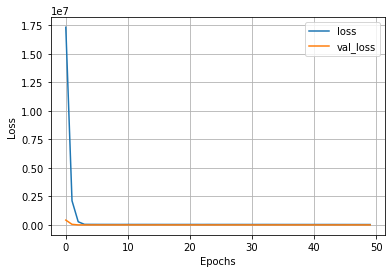

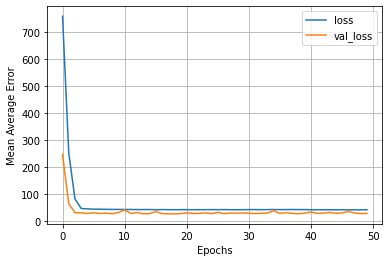

In [99]:
def plot_loss(hist):
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_mae(hist):
    plt.plot(hist.history['mae'], label='loss')
    plt.plot(hist.history['val_mae'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(history)
plot_mae(history)

In [240]:
def accuracy_score(predicted, actual, threshold):
    correct = 0
    incorrect = 0
    
    for idx in range(len(predicted)):
        pred = predicted[idx]
        act = actual[idx]
        
        diff = abs(act - pred)
        diff_pct = diff/(act + 0.01)
        
        if diff_pct <= threshold:
            correct += 1
        else:
            incorrect += 1
            
    accuracy = (correct / len(predicted)) * 100
    
    print('Weighted Accuracy w/ Threshold of ' + str(threshold * 100) + '%: ' + str(accuracy) + '%.')

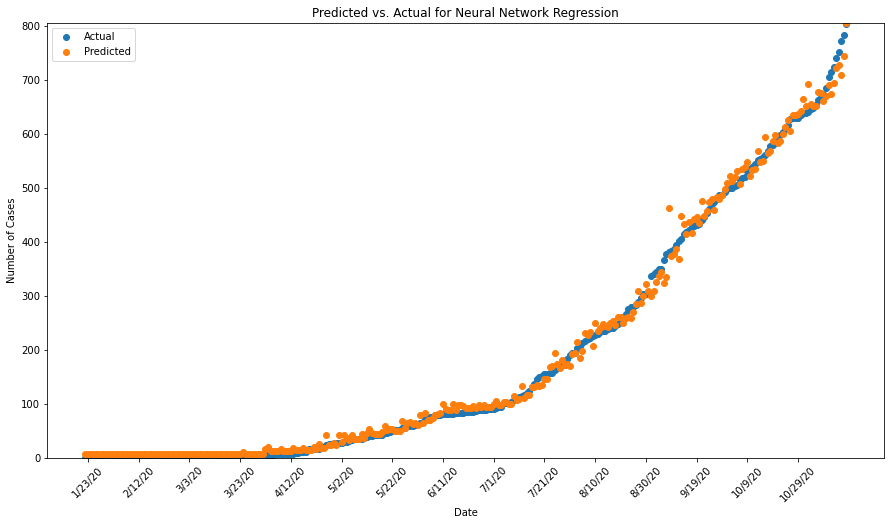

R2 Score: 0.9962956244835861
Weighted Accuracy w/ Threshold of 10.0%: 56.47840531561462%.


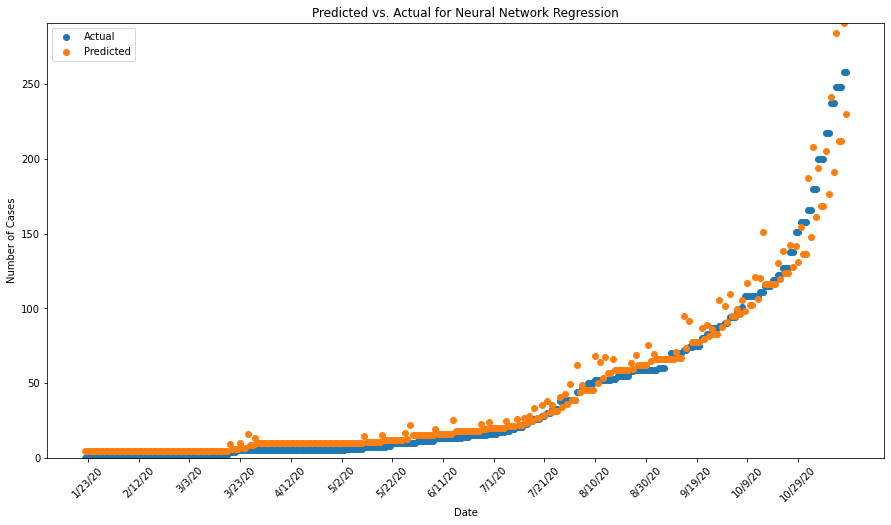

R2 Score: 0.970950566839319
Weighted Accuracy w/ Threshold of 10.0%: 29.2358803986711%.


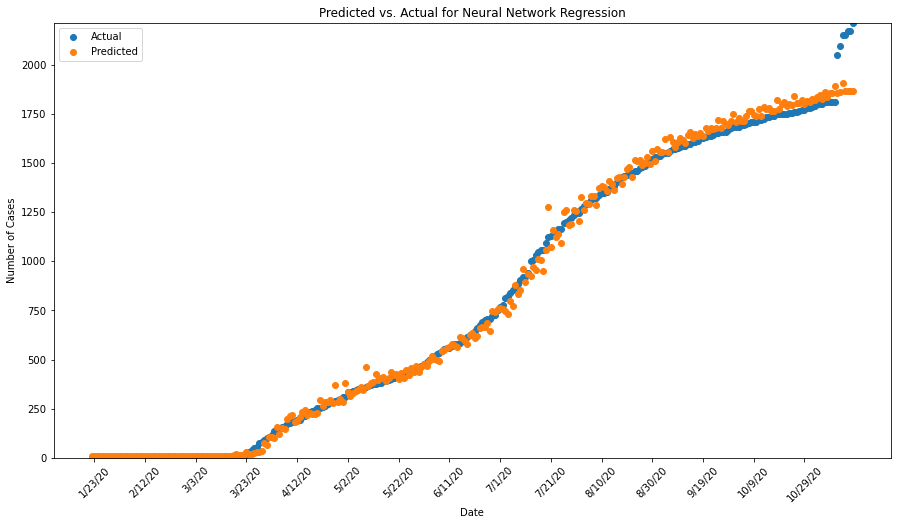

R2 Score: 0.9939409037736858
Weighted Accuracy w/ Threshold of 10.0%: 69.43521594684385%.


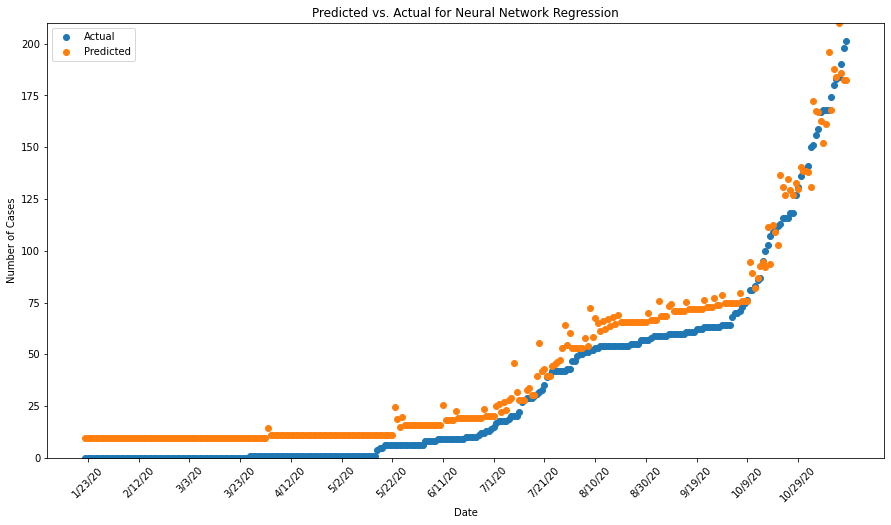

R2 Score: 0.947663347083772
Weighted Accuracy w/ Threshold of 10.0%: 15.282392026578073%.


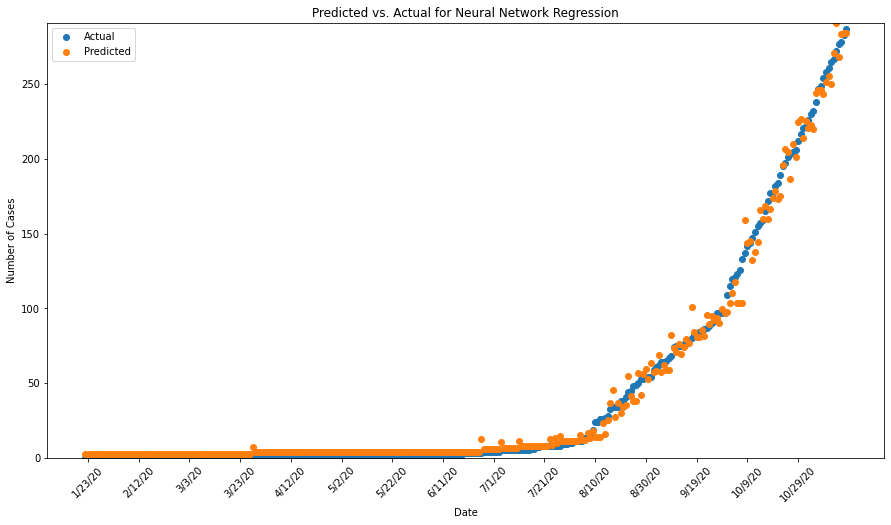

R2 Score: 0.9938466719324685
Weighted Accuracy w/ Threshold of 10.0%: 26.910299003322258%.


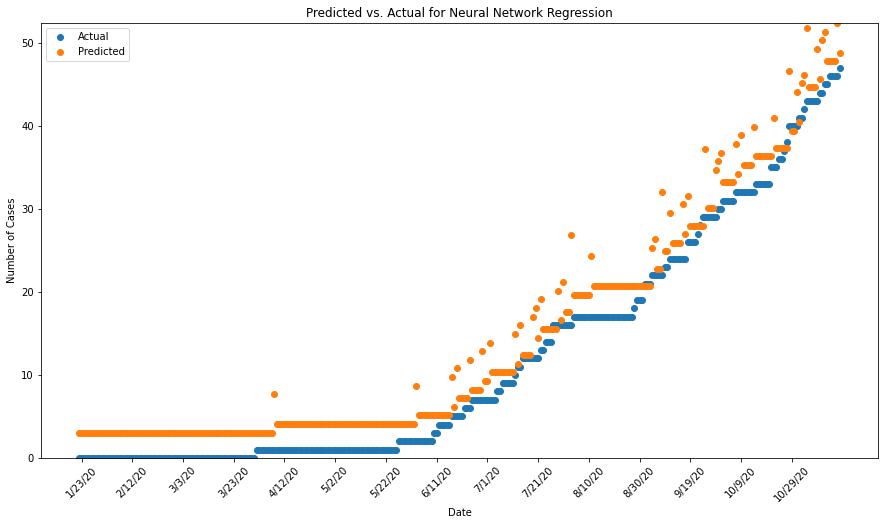

R2 Score: 0.943045967096573
Weighted Accuracy w/ Threshold of 10.0%: 19.269102990033225%.


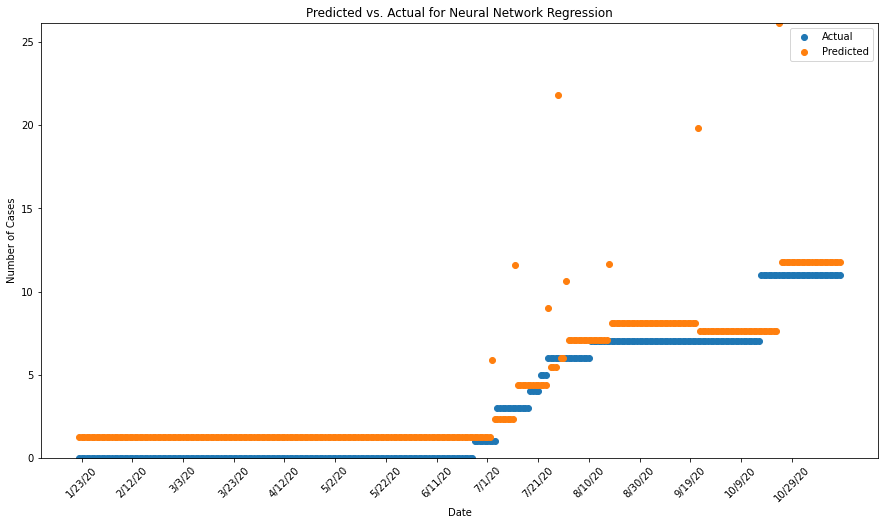

R2 Score: 0.7568296321124132
Weighted Accuracy w/ Threshold of 10.0%: 21.262458471760798%.


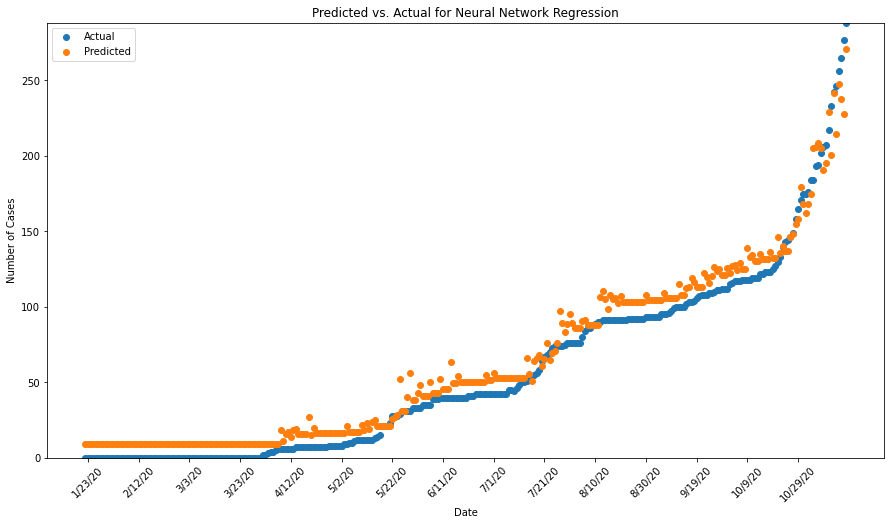

R2 Score: 0.9644310318528757
Weighted Accuracy w/ Threshold of 10.0%: 24.25249169435216%.


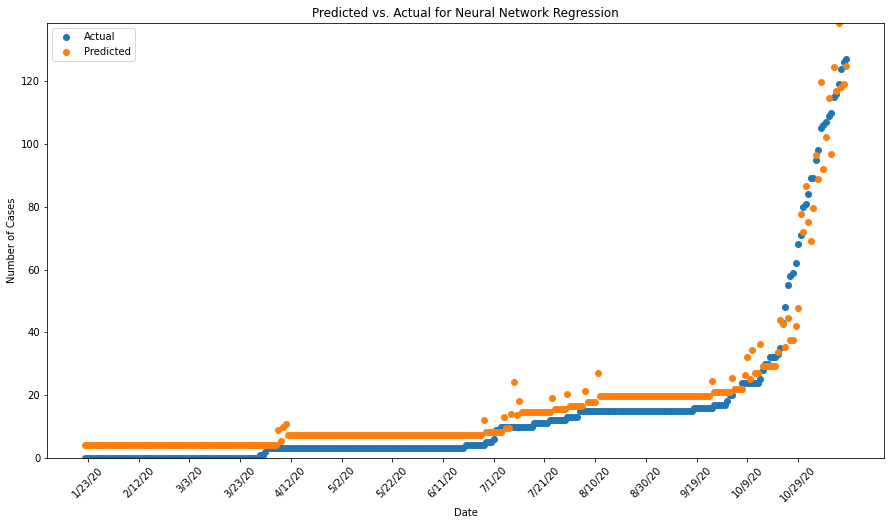

R2 Score: 0.9449704999768547
Weighted Accuracy w/ Threshold of 10.0%: 9.966777408637874%.


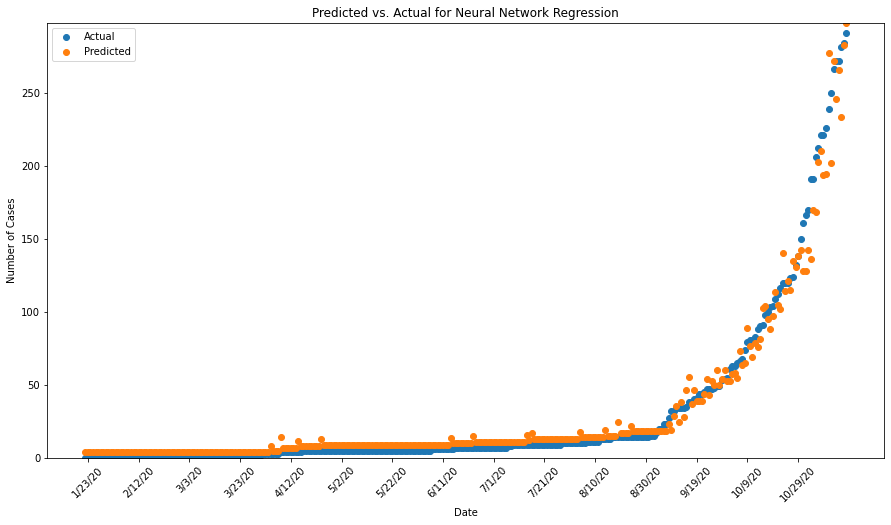

R2 Score: 0.9726726624137025
Weighted Accuracy w/ Threshold of 10.0%: 13.621262458471762%.


In [241]:
def graph_predicted_vs_actual_nn(X_input, Y_input, predictions):

    X = Y_input.index.values
    Y = Y_input[Y_input.columns[0]].to_numpy()
    
    Y_min = np.amin(Y)
    pred_min = np.amin(predictions)
    Y_min = np.minimum(Y_min, pred_min)

    Y_max = np.amax(Y)
    pred_max = np.amax(predictions)
    Y_max = np.maximum(Y_max, pred_max)

    plt.figure(figsize=(15,8))
    plt.scatter(X, Y, label='Actual')
    plt.scatter(X, predictions, label='Predicted')
    plt.ylim(Y_min, Y_max)
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.xticks(X[1::20], rotation=45)
    plt.title("Predicted vs. Actual for Neural Network Regression")
    plt.legend()
    plt.show()
    
    
for county_idx in range(len(X_test_list)):
    predictions = model.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)

In [246]:
# Model creation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=5)

history_1 = model_1.fit(X_train_scaled, Y_train,
                    epochs=30,
                    verbose=2,
                    validation_split=0.1,
                       callbacks=[es])

Epoch 1/30
26549/26549 - 21s - loss: 2587885.7500 - mae: 234.0580 - val_loss: 11604.2383 - val_mae: 30.8481
Epoch 2/30
26549/26549 - 20s - loss: 55749.9336 - mae: 48.6363 - val_loss: 10287.1797 - val_mae: 26.8638
Epoch 3/30
26549/26549 - 20s - loss: 56263.5977 - mae: 47.5032 - val_loss: 10579.6709 - val_mae: 27.1578
Epoch 4/30
26549/26549 - 23s - loss: 52606.7500 - mae: 48.1724 - val_loss: 10213.8486 - val_mae: 33.7746
Epoch 5/30
26549/26549 - 23s - loss: 52735.8008 - mae: 47.3519 - val_loss: 8842.5850 - val_mae: 27.3022
Epoch 6/30
26549/26549 - 21s - loss: 49349.5234 - mae: 46.3337 - val_loss: 9855.6064 - val_mae: 29.2660
Epoch 7/30
26549/26549 - 21s - loss: 48681.3750 - mae: 46.6703 - val_loss: 9020.3945 - val_mae: 40.6041
Epoch 00007: early stopping


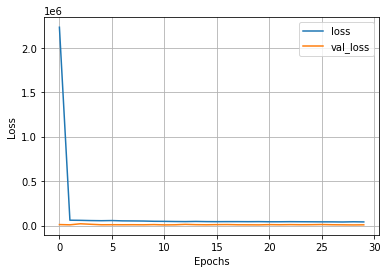

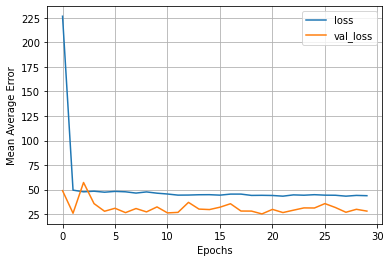

In [157]:
plot_loss(history_1)
plot_mae(history_1)

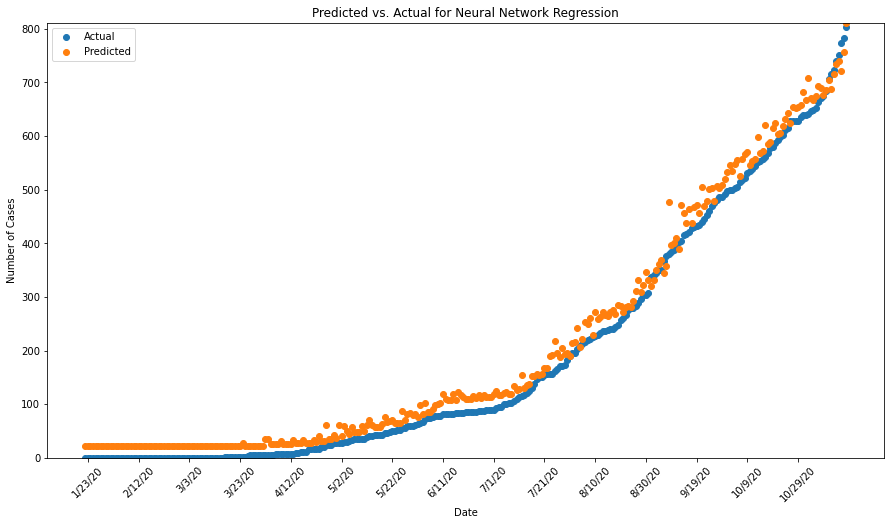

R2 Score: 0.9871375209362068
Weighted Accuracy w/ Threshold of 10.0%: 30.89700996677741%.


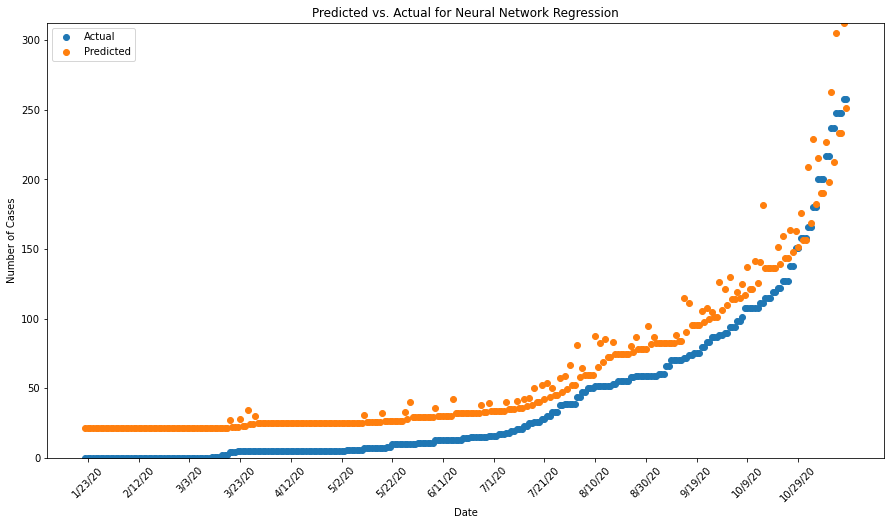

R2 Score: 0.852531375398494
Weighted Accuracy w/ Threshold of 10.0%: 5.3156146179401995%.


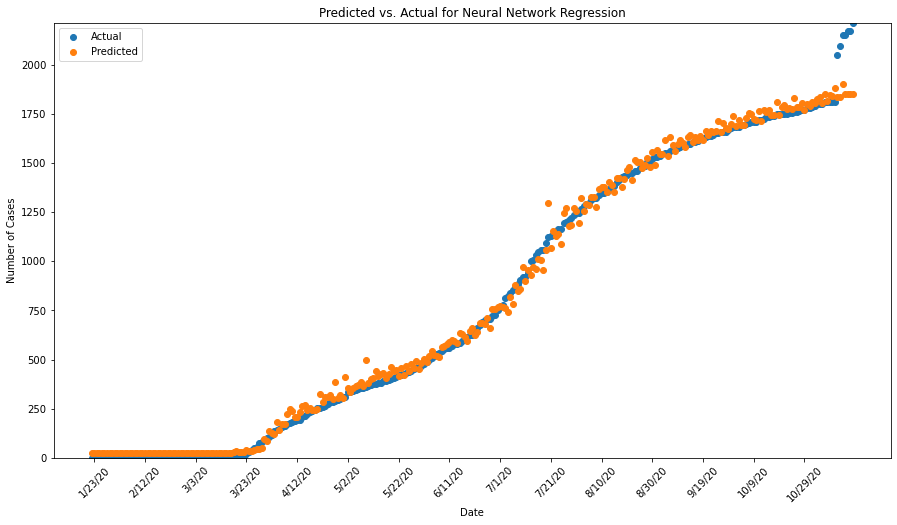

R2 Score: 0.9929366143563201
Weighted Accuracy w/ Threshold of 10.0%: 67.109634551495%.


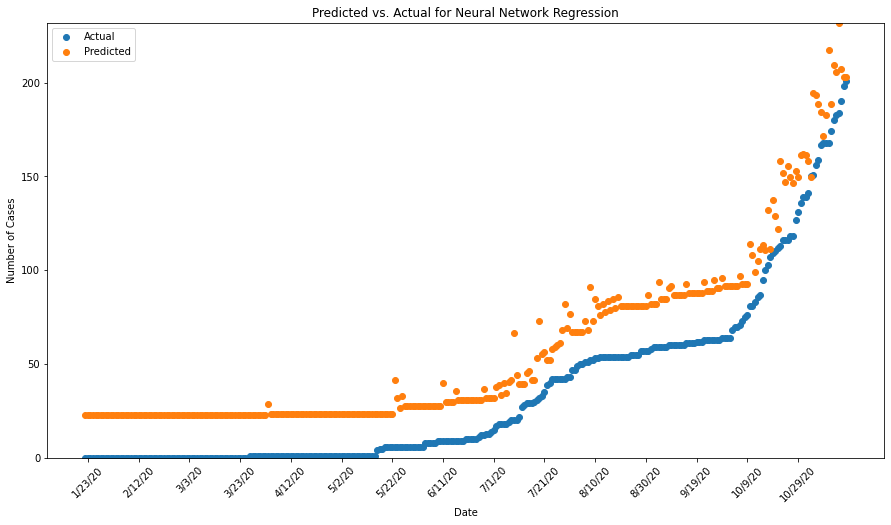

R2 Score: 0.7471551904418419
Weighted Accuracy w/ Threshold of 10.0%: 2.990033222591362%.


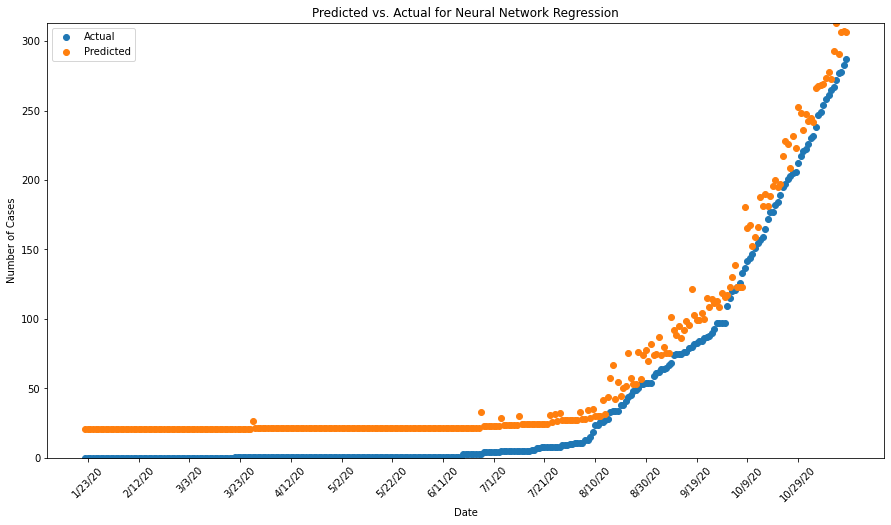

R2 Score: 0.9262732855377509
Weighted Accuracy w/ Threshold of 10.0%: 10.631229235880399%.


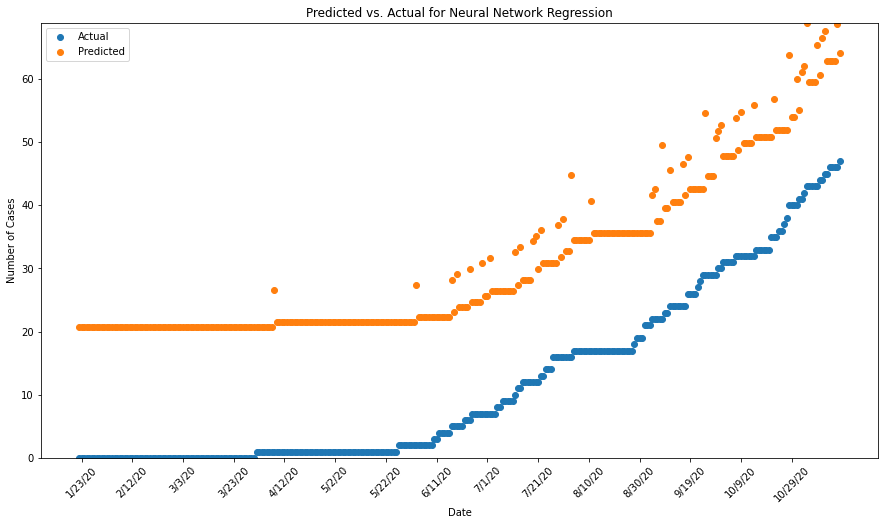

R2 Score: -1.2376699285978758
Weighted Accuracy w/ Threshold of 10.0%: 0.0%.


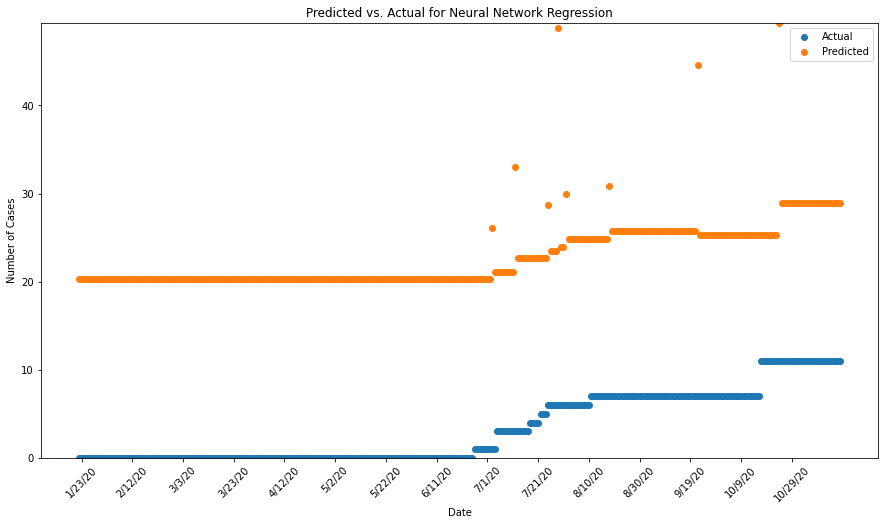

R2 Score: -24.986717486881556
Weighted Accuracy w/ Threshold of 10.0%: 0.0%.


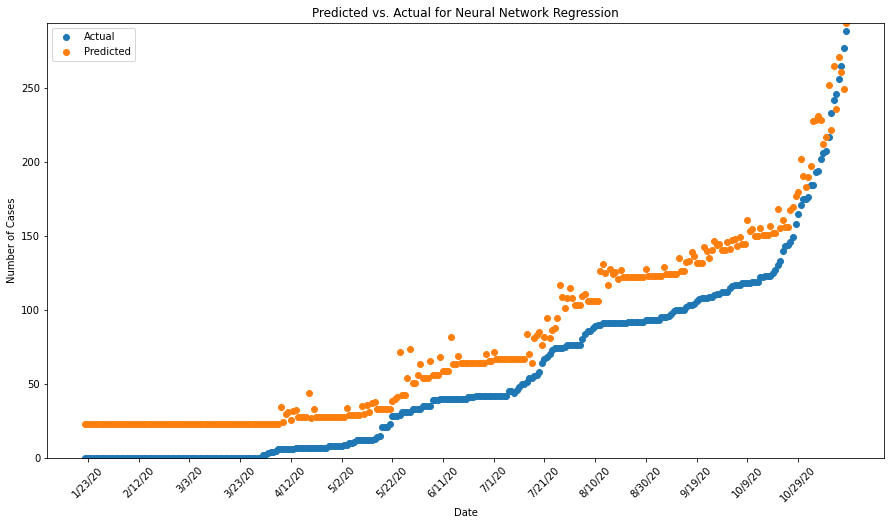

R2 Score: 0.8342707490706784
Weighted Accuracy w/ Threshold of 10.0%: 4.983388704318937%.


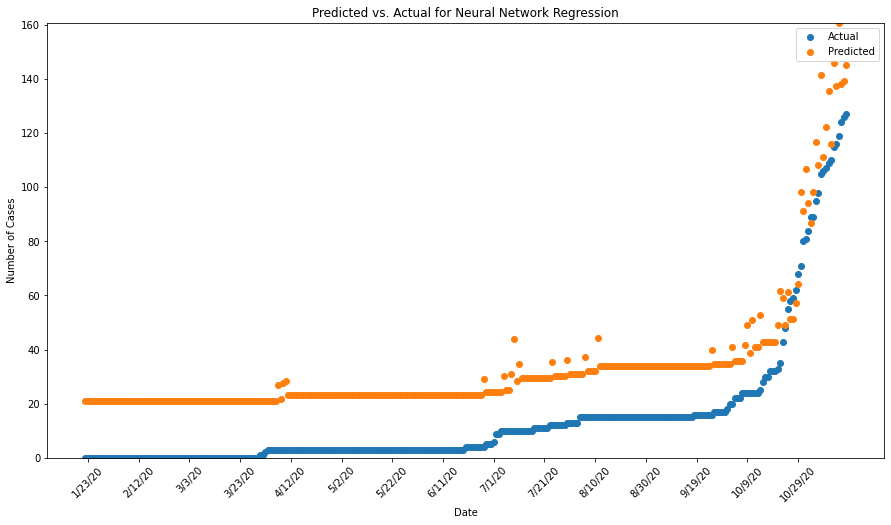

R2 Score: 0.34686946797389895
Weighted Accuracy w/ Threshold of 10.0%: 1.9933554817275747%.


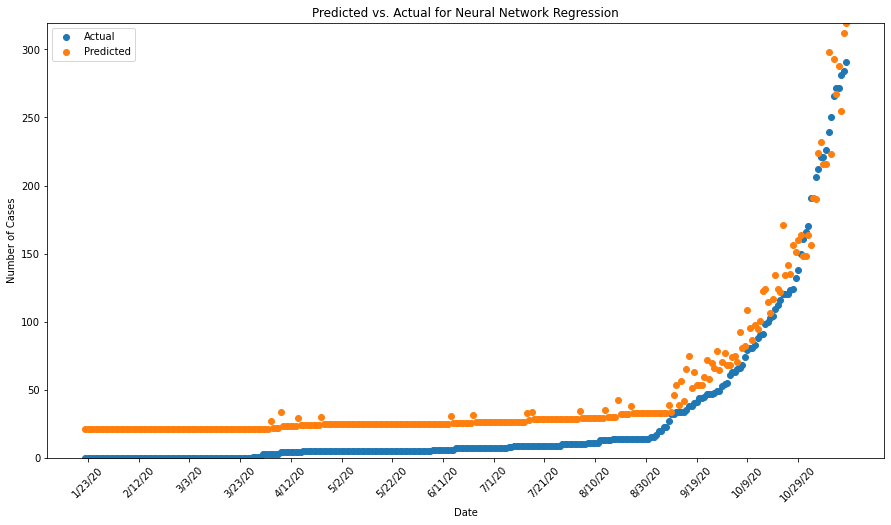

R2 Score: 0.8701266141355949
Weighted Accuracy w/ Threshold of 10.0%: 6.976744186046512%.


In [247]:
for county_idx in range(len(X_test_list)):
    predictions = model_1.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)

In [250]:
# Model creation
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=5)

history_2 = model_2.fit(X_train_scaled, Y_train,
                    epochs=30,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/30
26549/26549 - 22s - loss: 2323268.7500 - mae: 197.1865 - val_loss: 9129.4121 - val_mae: 28.3684
Epoch 2/30
26549/26549 - 23s - loss: 63708.6094 - mae: 51.6169 - val_loss: 36907.9141 - val_mae: 57.5650
Epoch 3/30
26549/26549 - 21s - loss: 61403.2031 - mae: 51.0768 - val_loss: 12159.0234 - val_mae: 37.2501
Epoch 4/30
26549/26549 - 32s - loss: 58123.6094 - mae: 50.2818 - val_loss: 8707.4609 - val_mae: 25.2862
Epoch 5/30
26549/26549 - 25s - loss: 56066.5469 - mae: 49.6287 - val_loss: 10185.3359 - val_mae: 27.2270
Epoch 6/30
26549/26549 - 27s - loss: 52200.8984 - mae: 48.9050 - val_loss: 10806.3701 - val_mae: 26.3825
Epoch 7/30
26549/26549 - 22s - loss: 50844.2109 - mae: 48.3183 - val_loss: 12124.7910 - val_mae: 33.5755
Epoch 8/30
26549/26549 - 21s - loss: 49463.4609 - mae: 47.5808 - val_loss: 9321.7695 - val_mae: 28.5291
Epoch 9/30
26549/26549 - 22s - loss: 49047.2656 - mae: 47.1994 - val_loss: 9341.4072 - val_mae: 31.0934
Epoch 00009: early stopping


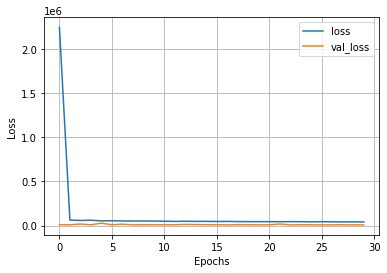

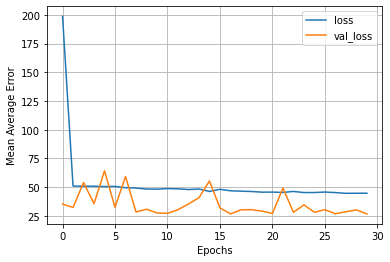

In [165]:
plot_loss(history_2)
plot_mae(history_2)

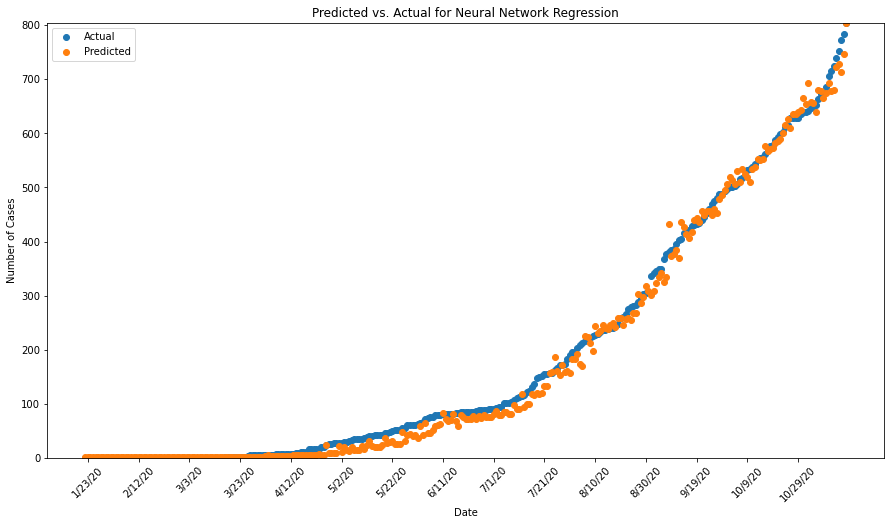

R2 Score: 0.9954151902598474
Weighted Accuracy w/ Threshold of 10.0%: 39.202657807308974%.


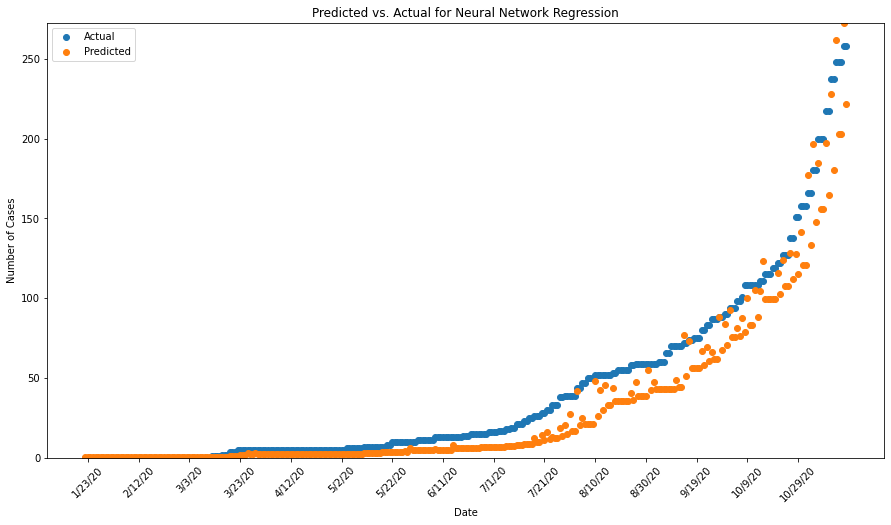

R2 Score: 0.9167736022706515
Weighted Accuracy w/ Threshold of 10.0%: 6.976744186046512%.


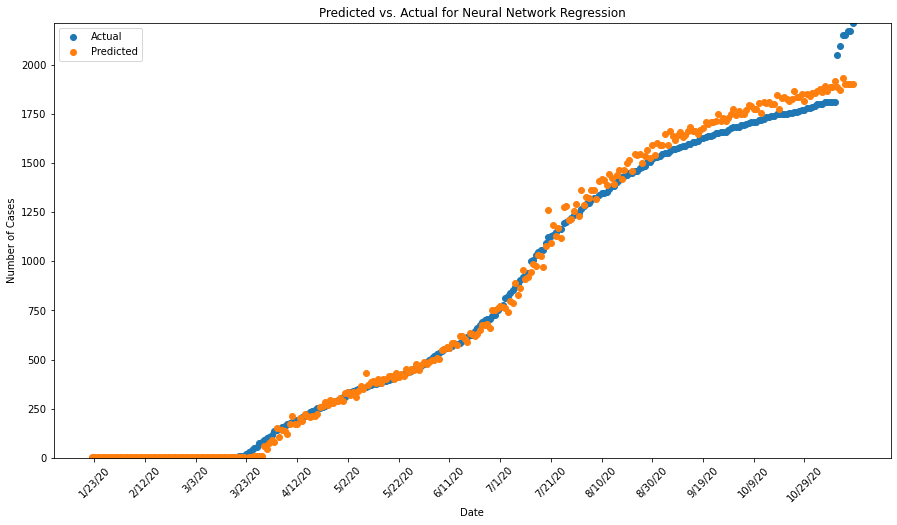

R2 Score: 0.9933134383413711
Weighted Accuracy w/ Threshold of 10.0%: 69.76744186046511%.


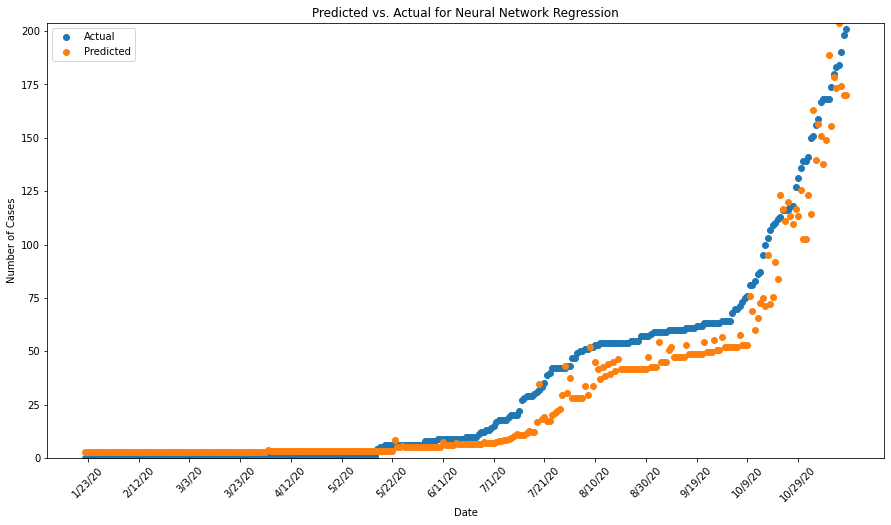

R2 Score: 0.9265952768462327
Weighted Accuracy w/ Threshold of 10.0%: 6.976744186046512%.


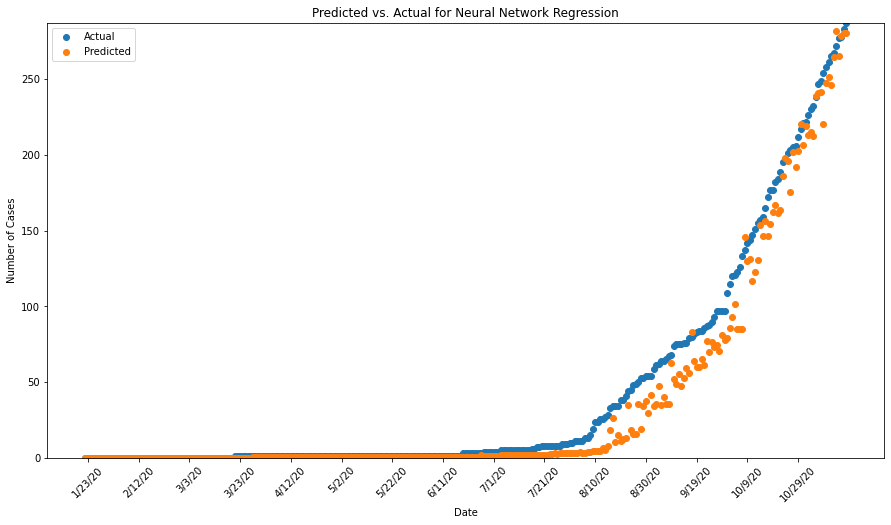

R2 Score: 0.9699111898002037
Weighted Accuracy w/ Threshold of 10.0%: 11.295681063122924%.


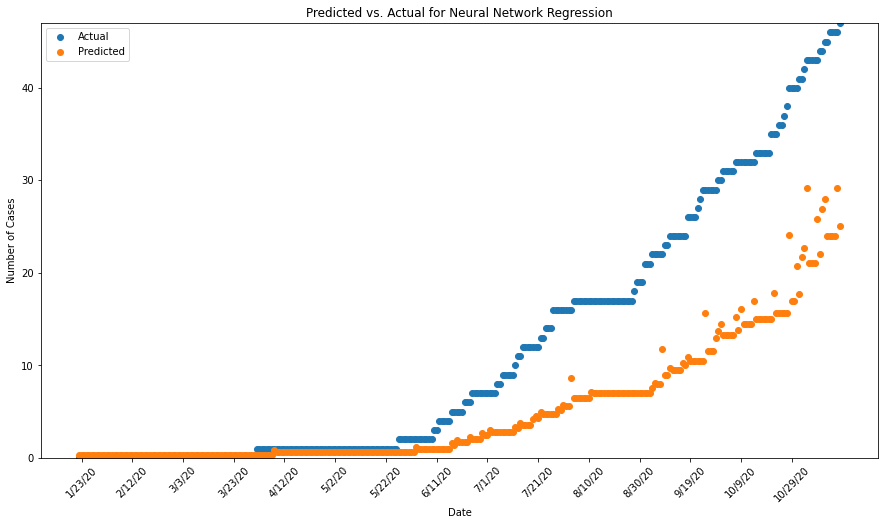

R2 Score: -1.136635453855778
Weighted Accuracy w/ Threshold of 10.0%: 0.0%.


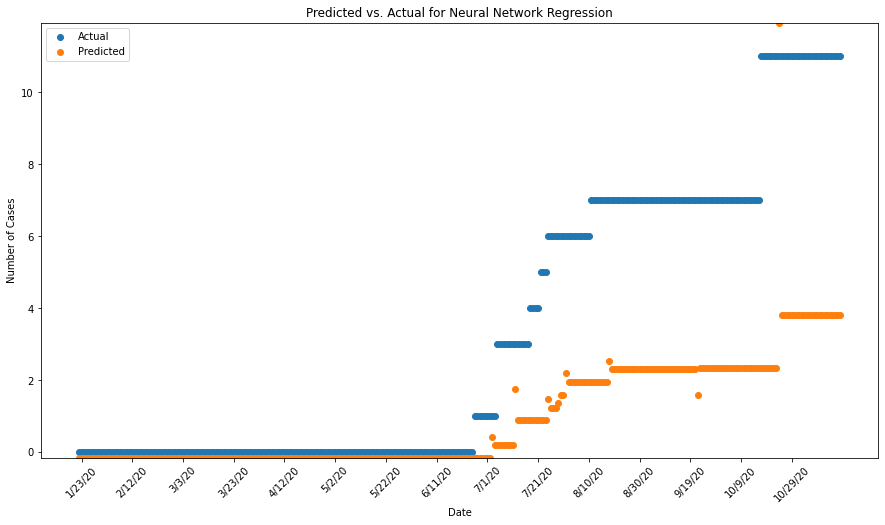

R2 Score: -4.578720479167279
Weighted Accuracy w/ Threshold of 10.0%: 0.33222591362126247%.


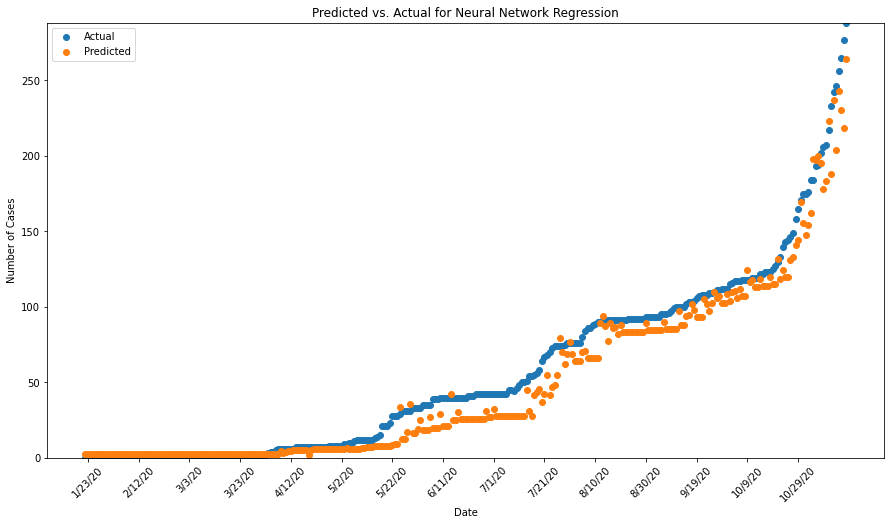

R2 Score: 0.9534686420146733
Weighted Accuracy w/ Threshold of 10.0%: 24.916943521594686%.


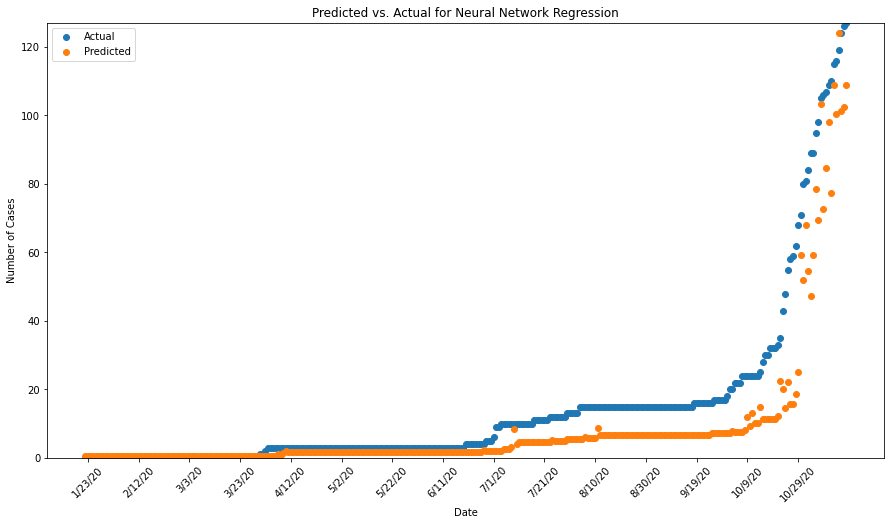

R2 Score: 0.7458951016192739
Weighted Accuracy w/ Threshold of 10.0%: 1.3289036544850499%.


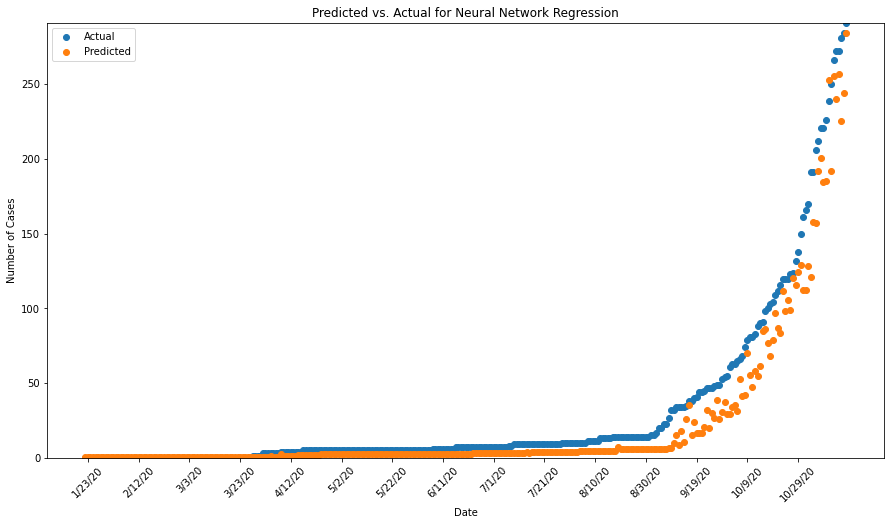

R2 Score: 0.9227974224793332
Weighted Accuracy w/ Threshold of 10.0%: 3.6544850498338874%.


In [251]:
for county_idx in range(len(X_test_list)):
    predictions = model_2.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)

In [245]:
# Model creation
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])

history_3 = model_3.fit(X_train_scaled, Y_train,
                    epochs=30,
                    verbose=2,
                    validation_split=0.1)

Epoch 1/30
26549/26549 - 28s - loss: 628209.8750 - mae: 116.8184 - val_loss: 10908.1328 - val_mae: 38.7333
Epoch 2/30
26549/26549 - 28s - loss: 281600.5938 - mae: 86.6545 - val_loss: 8847.2900 - val_mae: 34.5725
Epoch 3/30
26549/26549 - 29s - loss: 206186.7500 - mae: 78.3343 - val_loss: 14331.7568 - val_mae: 46.4126
Epoch 4/30
26549/26549 - 37s - loss: 169435.7812 - mae: 68.0971 - val_loss: 71520.2656 - val_mae: 100.1123
Epoch 5/30
26549/26549 - 32s - loss: 137118.2500 - mae: 68.0443 - val_loss: 20489.8398 - val_mae: 59.3109
Epoch 6/30
26549/26549 - 36s - loss: 141112.3750 - mae: 64.6979 - val_loss: 13569.4053 - val_mae: 62.5567
Epoch 7/30
26549/26549 - 36s - loss: 134328.8594 - mae: 59.8191 - val_loss: 8930.4072 - val_mae: 26.7494
Epoch 8/30
26549/26549 - 30s - loss: 112782.7031 - mae: 63.9241 - val_loss: 34017.7461 - val_mae: 71.6444
Epoch 9/30
26549/26549 - 29s - loss: 111071.8047 - mae: 62.3240 - val_loss: 10064.0586 - val_mae: 32.0344
Epoch 10/30
26549/26549 - 33s - loss: 99238.97

KeyboardInterrupt: 

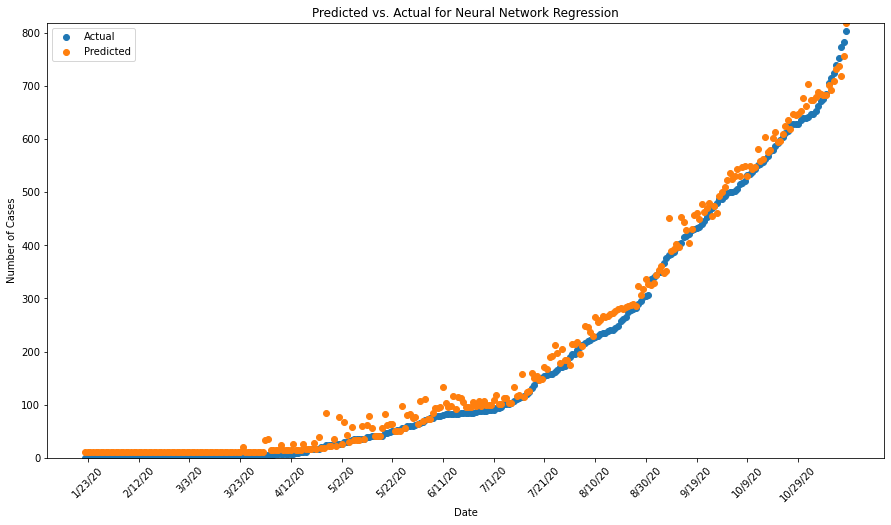

R2 Score: 0.9925650169695597
Weighted Accuracy w/ Threshold of 10.0%: 43.521594684385384%.


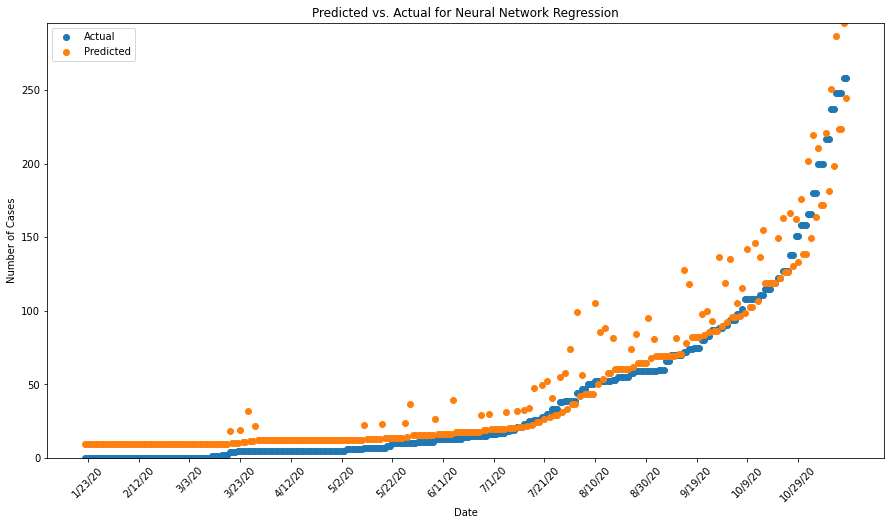

R2 Score: 0.9344145850761427
Weighted Accuracy w/ Threshold of 10.0%: 22.92358803986711%.


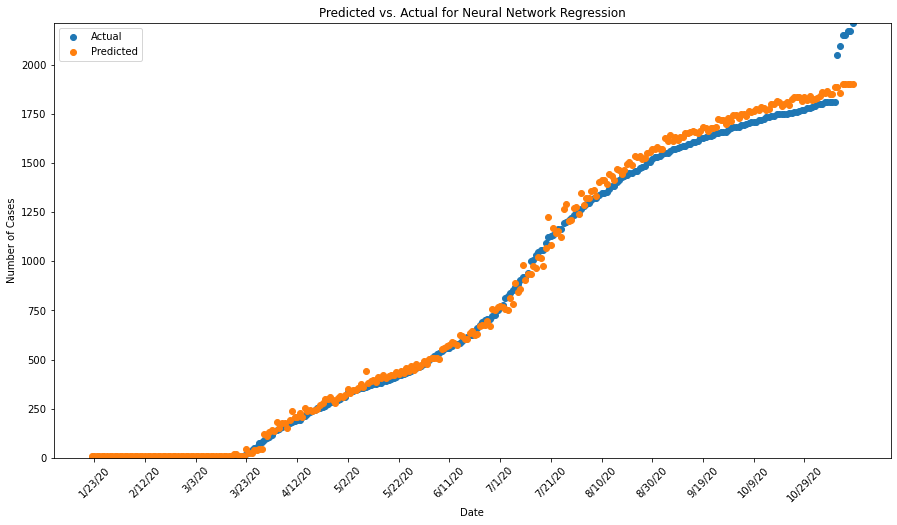

R2 Score: 0.9940159630720753
Weighted Accuracy w/ Threshold of 10.0%: 71.76079734219269%.


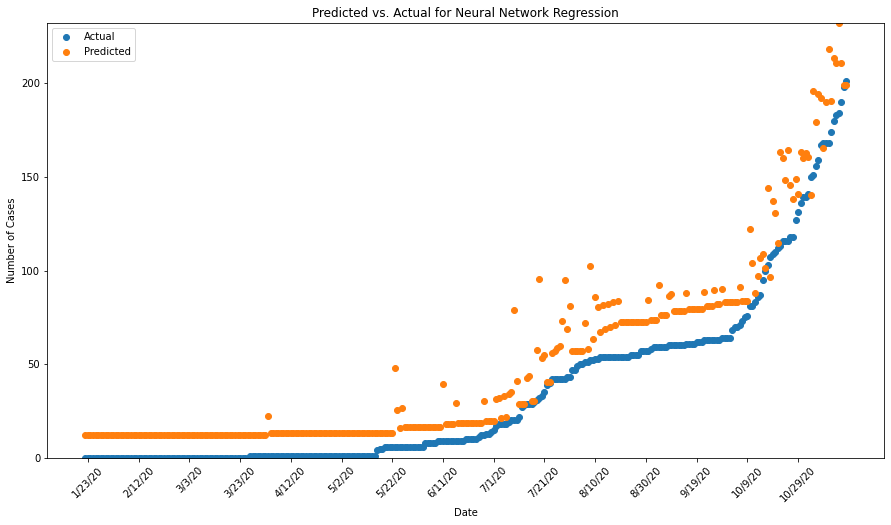

R2 Score: 0.8714927512175156
Weighted Accuracy w/ Threshold of 10.0%: 5.3156146179401995%.


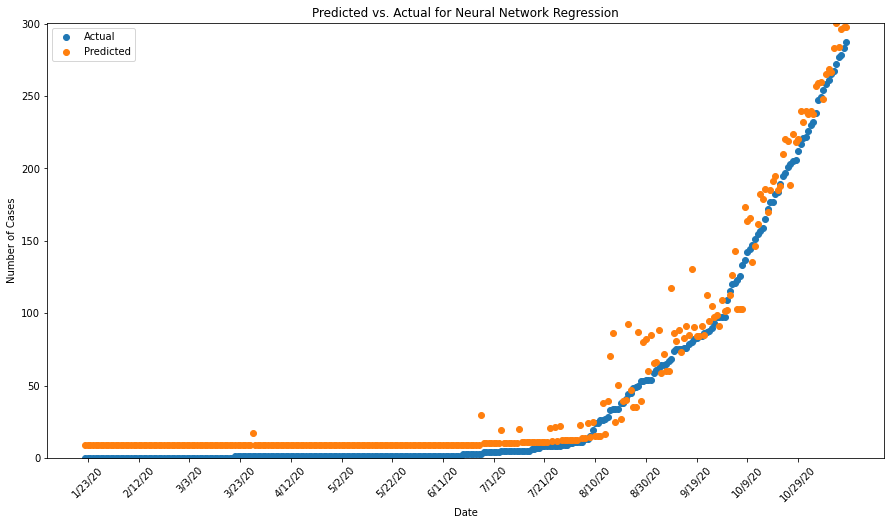

R2 Score: 0.9732293372782611
Weighted Accuracy w/ Threshold of 10.0%: 18.6046511627907%.


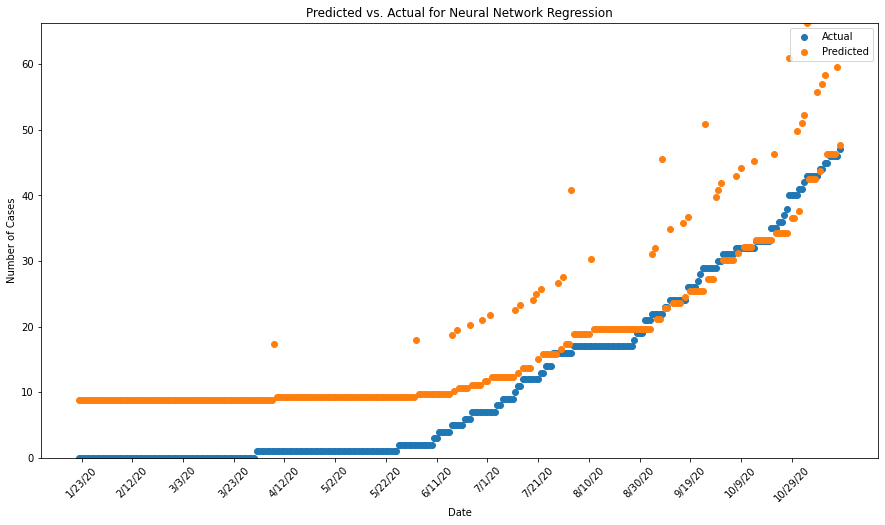

R2 Score: 0.6074404767857935
Weighted Accuracy w/ Threshold of 10.0%: 20.930232558139537%.


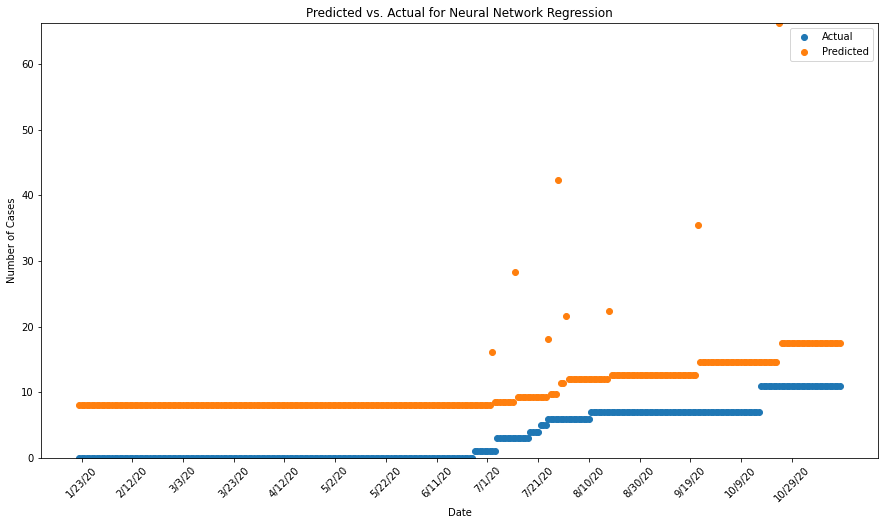

R2 Score: -1.6231304348703288
Weighted Accuracy w/ Threshold of 10.0%: 0.0%.


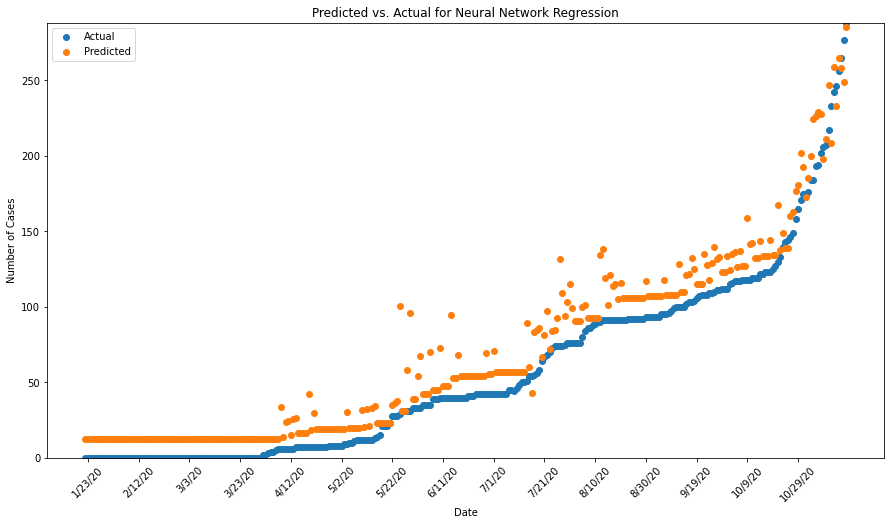

R2 Score: 0.9149597879355968
Weighted Accuracy w/ Threshold of 10.0%: 15.614617940199334%.


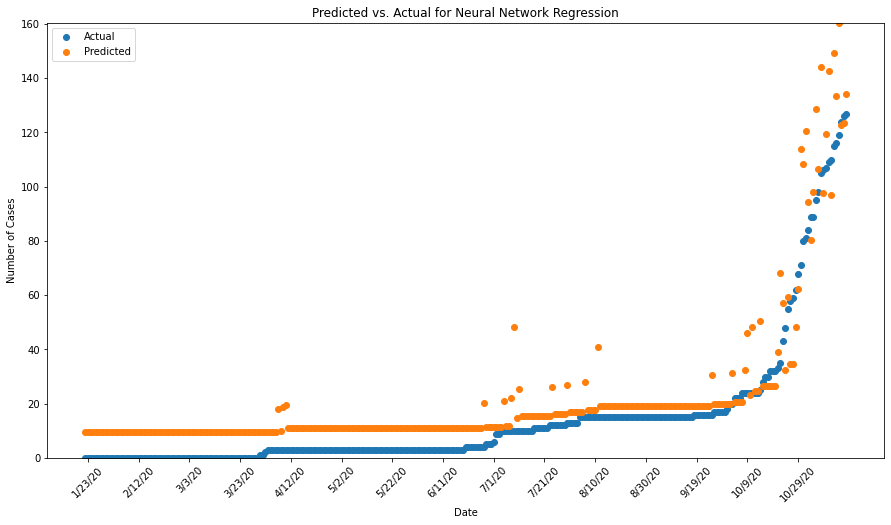

R2 Score: 0.8488678757992068
Weighted Accuracy w/ Threshold of 10.0%: 5.3156146179401995%.


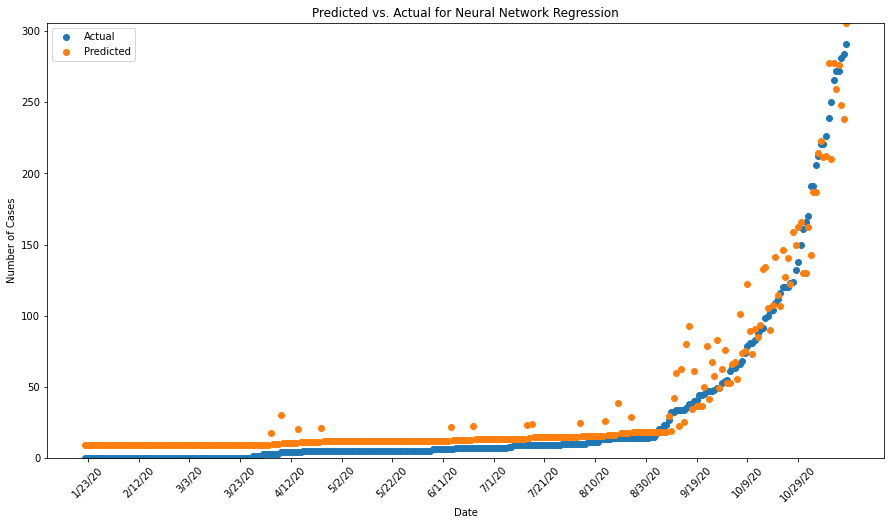

R2 Score: 0.9496444919367031
Weighted Accuracy w/ Threshold of 10.0%: 10.631229235880399%.


In [254]:
for county_idx in range(len(X_test_list)):
    predictions = model_3.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)

In [252]:
# Model creation
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_4.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=5)

history_4 = model_4.fit(X_train_scaled, Y_train,
                    epochs=30,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/30
26549/26549 - 19s - loss: 3156409.7500 - mae: 296.4706 - val_loss: 9125.1758 - val_mae: 30.0310
Epoch 2/30
26549/26549 - 19s - loss: 57595.8359 - mae: 48.0747 - val_loss: 8854.5928 - val_mae: 27.5714
Epoch 3/30
26549/26549 - 20s - loss: 56132.7852 - mae: 46.8212 - val_loss: 9762.9023 - val_mae: 28.2287
Epoch 4/30
26549/26549 - 24s - loss: 55415.8125 - mae: 46.8471 - val_loss: 16457.9316 - val_mae: 37.2410
Epoch 5/30
26549/26549 - 20s - loss: 53278.2969 - mae: 46.7252 - val_loss: 10547.2490 - val_mae: 33.5393
Epoch 6/30
26549/26549 - 20s - loss: 51964.2344 - mae: 46.7056 - val_loss: 10309.1504 - val_mae: 31.2890
Epoch 7/30
26549/26549 - 19s - loss: 52514.9609 - mae: 45.7447 - val_loss: 8671.8662 - val_mae: 26.6405
Epoch 8/30
26549/26549 - 19s - loss: 53443.7109 - mae: 45.6540 - val_loss: 9322.0449 - val_mae: 28.7662
Epoch 9/30
26549/26549 - 20s - loss: 51473.7266 - mae: 45.6640 - val_loss: 9576.7461 - val_mae: 28.9086
Epoch 10/30
26549/26549 - 19s - loss: 48302.3125 - mae: 45

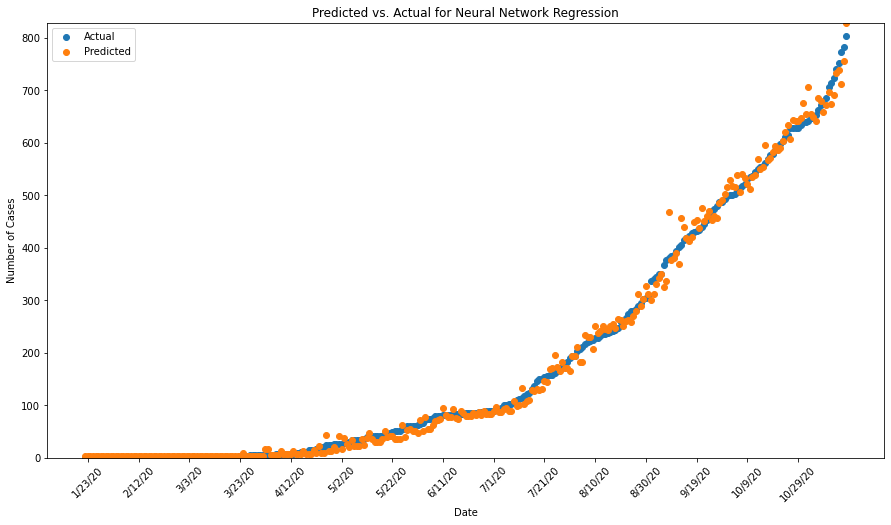

R2 Score: 0.9959040323550881
Weighted Accuracy w/ Threshold of 10.0%: 49.16943521594684%.


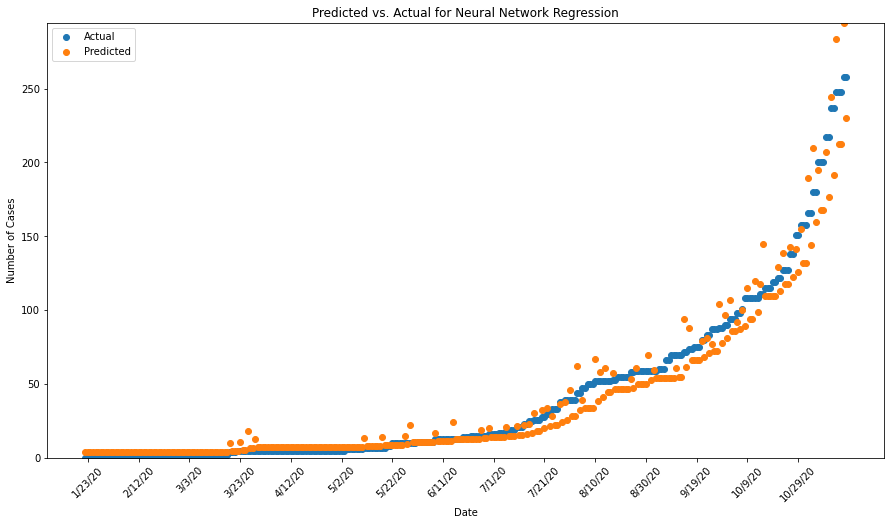

R2 Score: 0.9645230219512807
Weighted Accuracy w/ Threshold of 10.0%: 20.26578073089701%.


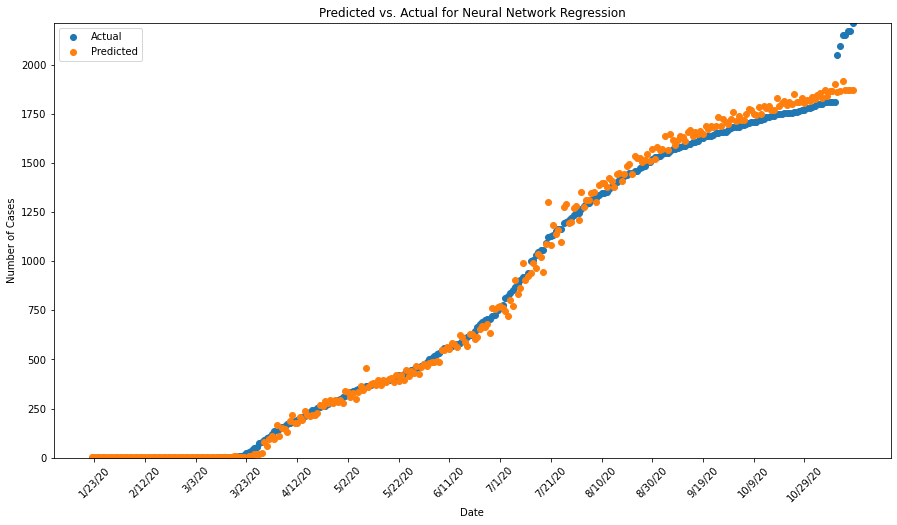

R2 Score: 0.9936131022253785
Weighted Accuracy w/ Threshold of 10.0%: 70.09966777408638%.


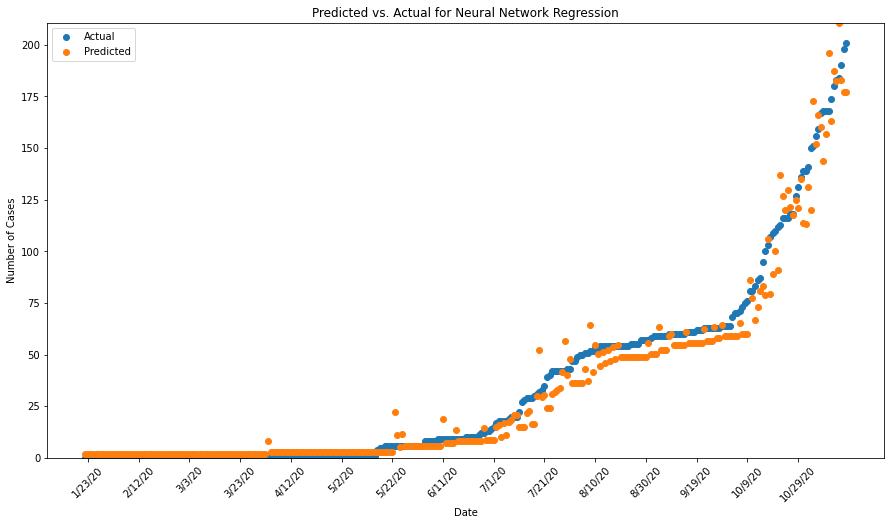

R2 Score: 0.9705491737518089
Weighted Accuracy w/ Threshold of 10.0%: 24.916943521594686%.


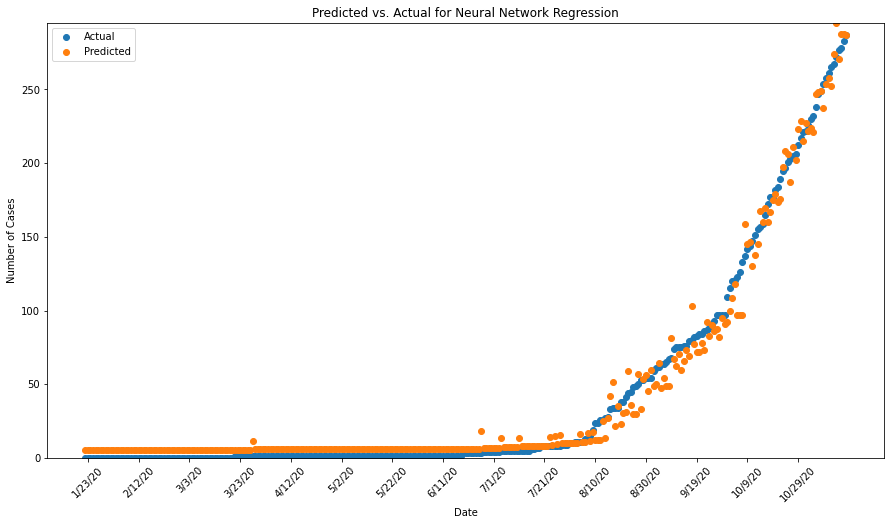

R2 Score: 0.9881510895070356
Weighted Accuracy w/ Threshold of 10.0%: 22.92358803986711%.


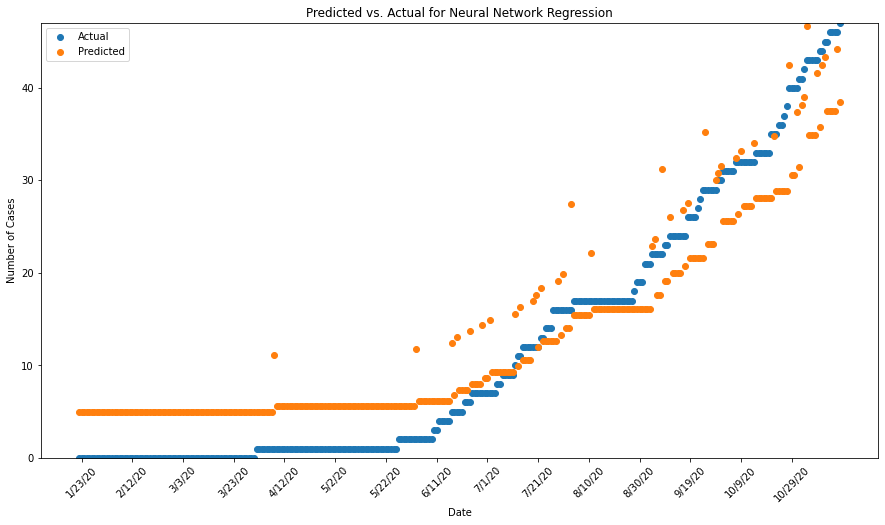

R2 Score: 0.8055711541994781
Weighted Accuracy w/ Threshold of 10.0%: 17.940199335548172%.


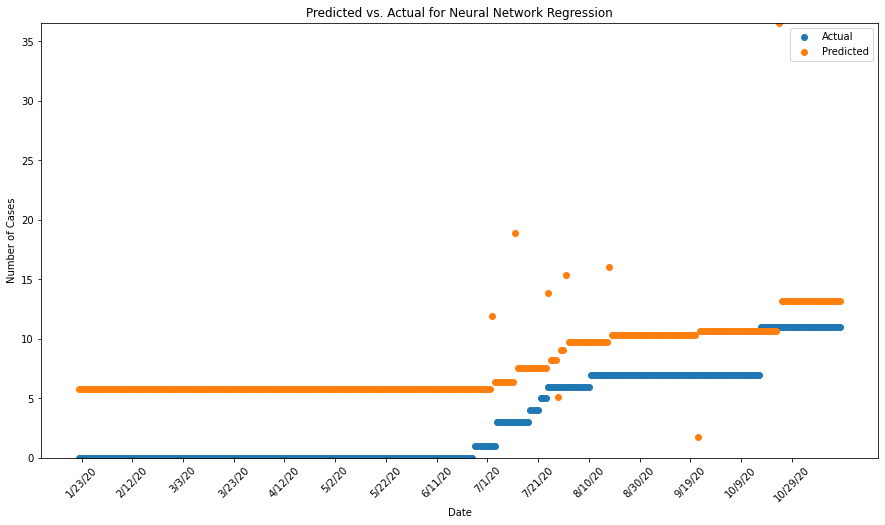

R2 Score: -1.6319494382351127
Weighted Accuracy w/ Threshold of 10.0%: 2.3255813953488373%.


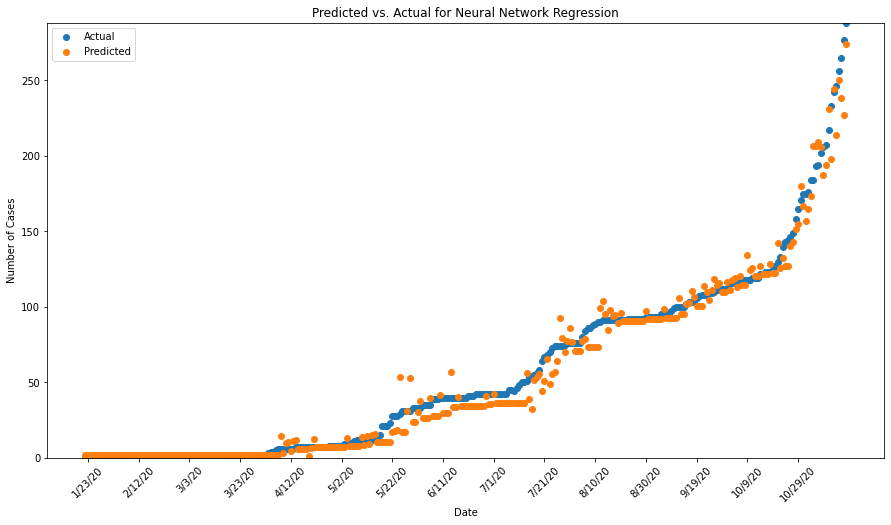

R2 Score: 0.9800873303370486
Weighted Accuracy w/ Threshold of 10.0%: 37.2093023255814%.


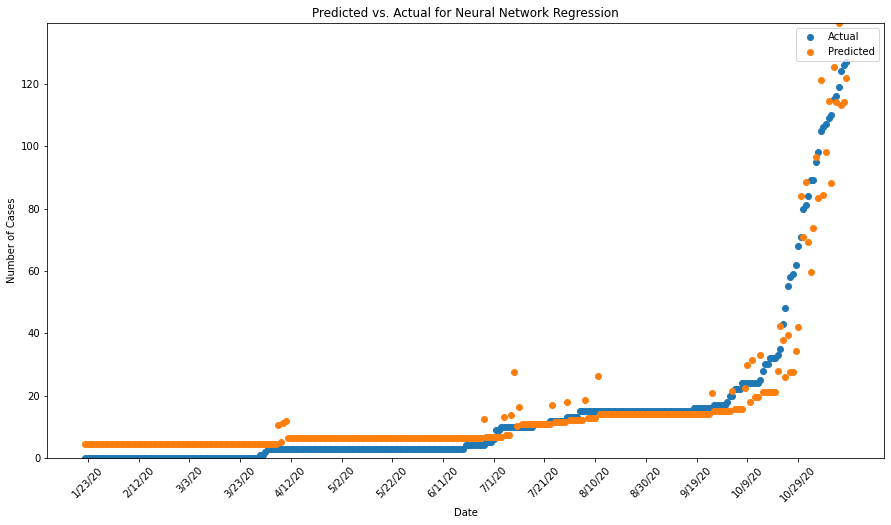

R2 Score: 0.9220772389957396
Weighted Accuracy w/ Threshold of 10.0%: 22.92358803986711%.


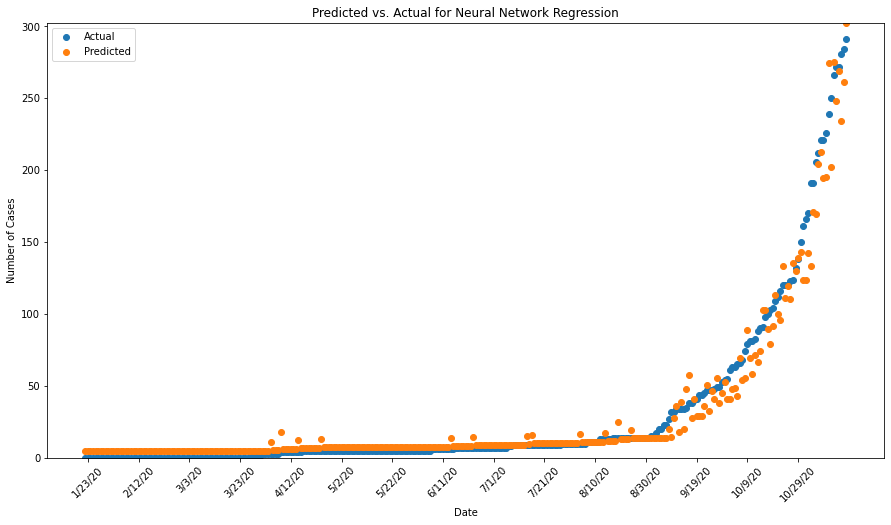

R2 Score: 0.9661226746194816
Weighted Accuracy w/ Threshold of 10.0%: 17.940199335548172%.


In [253]:
for county_idx in range(len(X_test_list)):
    predictions = model_4.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)

In [259]:
# Model creation
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_5.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse'])

es = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=5)

history_5 = model_5.fit(X_train_scaled, Y_train,
                    epochs=30,
                    verbose=2,
                    validation_split=0.2,
                    callbacks=[es])

Epoch 1/30
23599/23599 - 23s - loss: 35566976.0000 - mse: 35566976.0000 - val_loss: 12892094.0000 - val_mse: 12892094.0000
Epoch 2/30
23599/23599 - 23s - loss: 9132340.0000 - mse: 9132340.0000 - val_loss: 4133949.0000 - val_mse: 4133949.0000
Epoch 3/30
23599/23599 - 20s - loss: 4910502.0000 - mse: 4910502.0000 - val_loss: 2939049.0000 - val_mse: 2939049.0000
Epoch 4/30
23599/23599 - 23s - loss: 3168596.7500 - mse: 3168596.7500 - val_loss: 1910298.5000 - val_mse: 1910298.5000
Epoch 5/30
23599/23599 - 22s - loss: 1788611.3750 - mse: 1788611.3750 - val_loss: 1149477.7500 - val_mse: 1149477.7500
Epoch 6/30
23599/23599 - 20s - loss: 881580.8125 - mse: 881580.8125 - val_loss: 593451.8125 - val_mse: 593451.8125
Epoch 7/30
23599/23599 - 20s - loss: 266370.9688 - mse: 266370.9688 - val_loss: 196645.0625 - val_mse: 196645.0625
Epoch 8/30
23599/23599 - 21s - loss: 66697.9375 - mse: 66697.9375 - val_loss: 97089.3906 - val_mse: 97089.3906
Epoch 9/30
23599/23599 - 24s - loss: 45824.2422 - mse: 45824

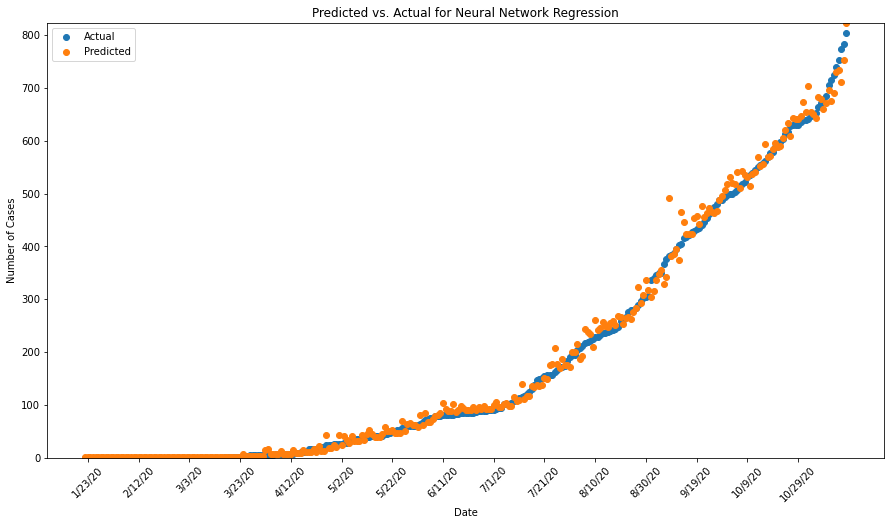

R2 Score: 0.9956524480290969
Weighted Accuracy w/ Threshold of 10.0%: 58.139534883720934%.


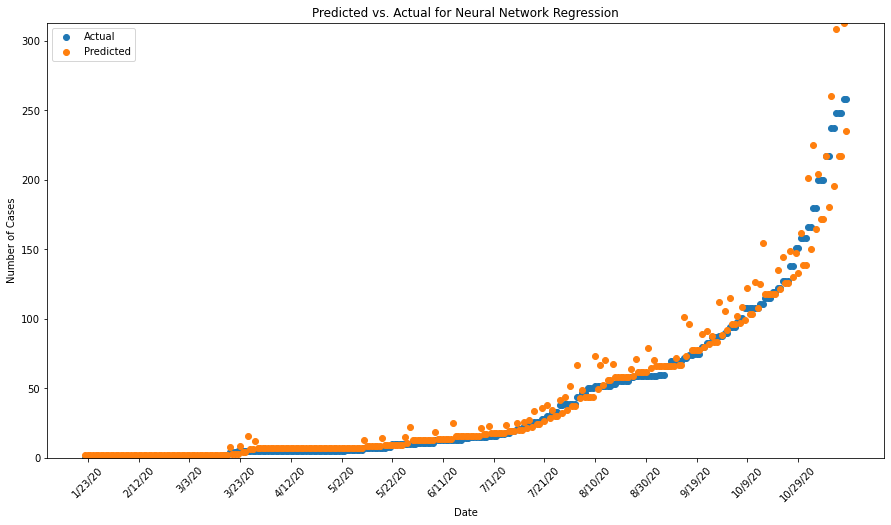

R2 Score: 0.969284505081119
Weighted Accuracy w/ Threshold of 10.0%: 35.548172757475086%.


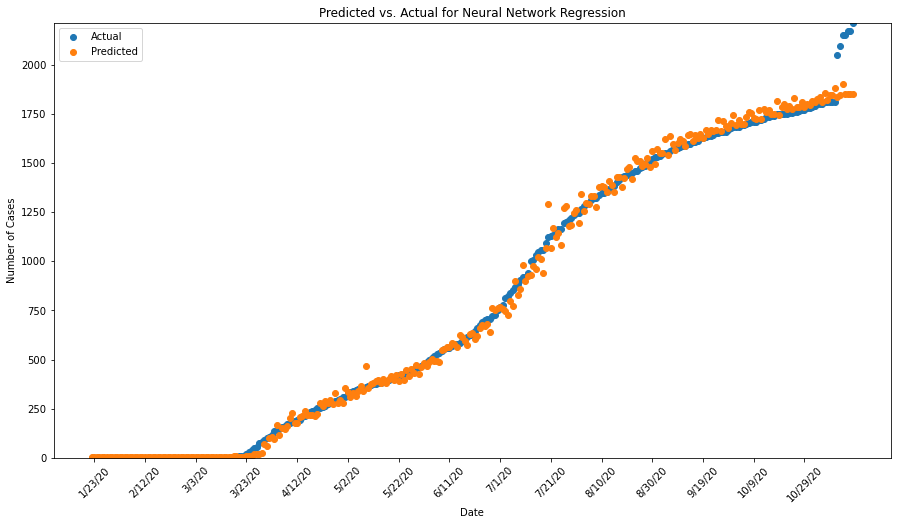

R2 Score: 0.9936845361009622
Weighted Accuracy w/ Threshold of 10.0%: 68.77076411960132%.


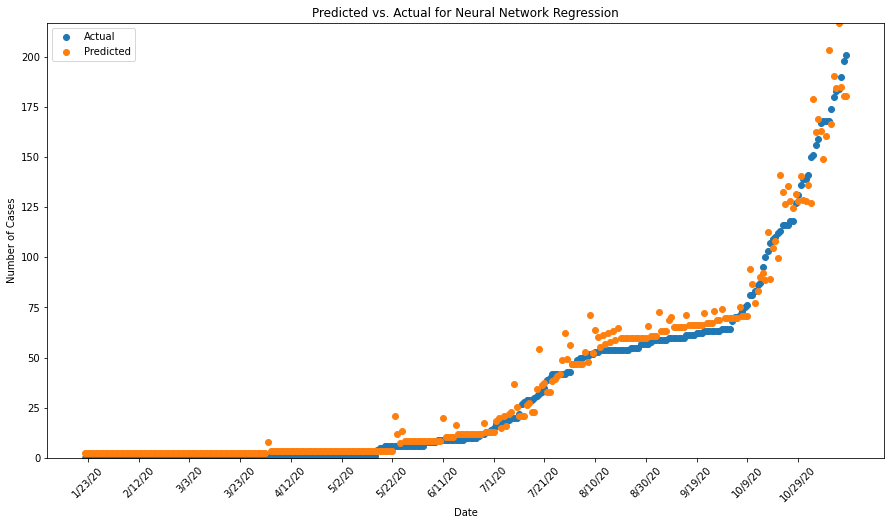

R2 Score: 0.9791424654039911
Weighted Accuracy w/ Threshold of 10.0%: 33.222591362126245%.


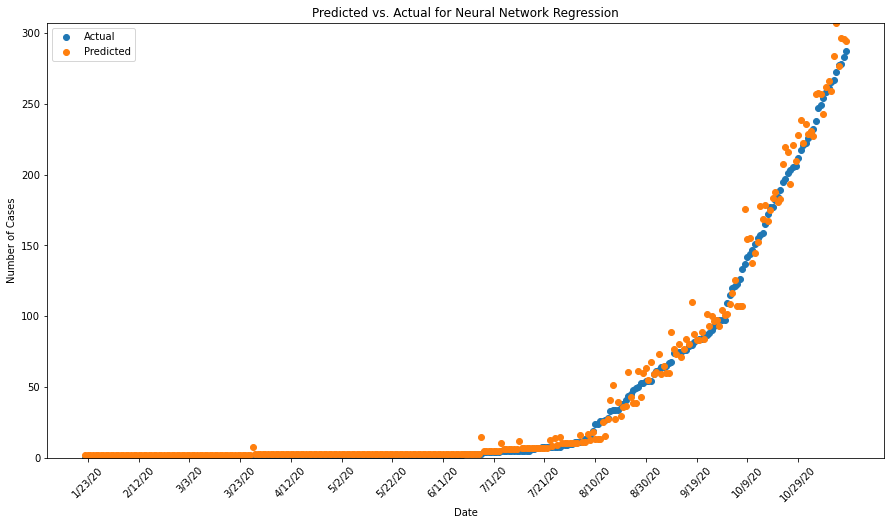

R2 Score: 0.9917203272283119
Weighted Accuracy w/ Threshold of 10.0%: 27.906976744186046%.


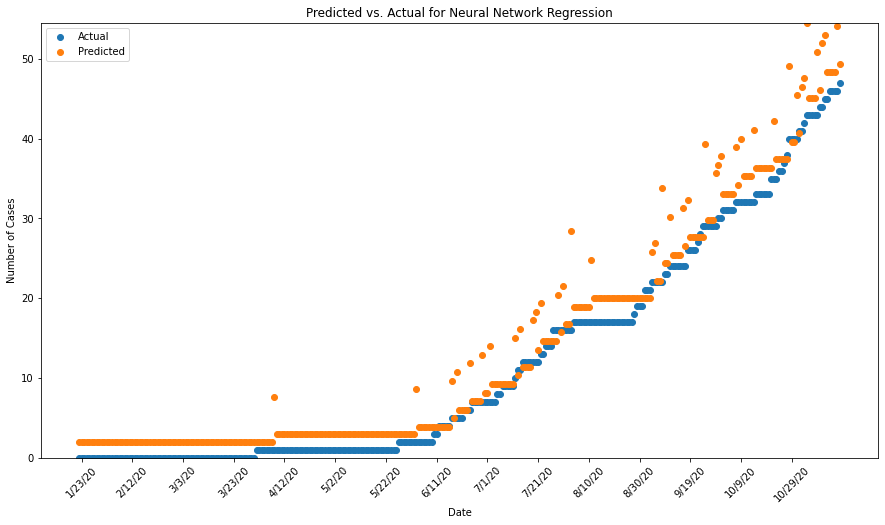

R2 Score: 0.9537006772872137
Weighted Accuracy w/ Threshold of 10.0%: 25.581395348837212%.


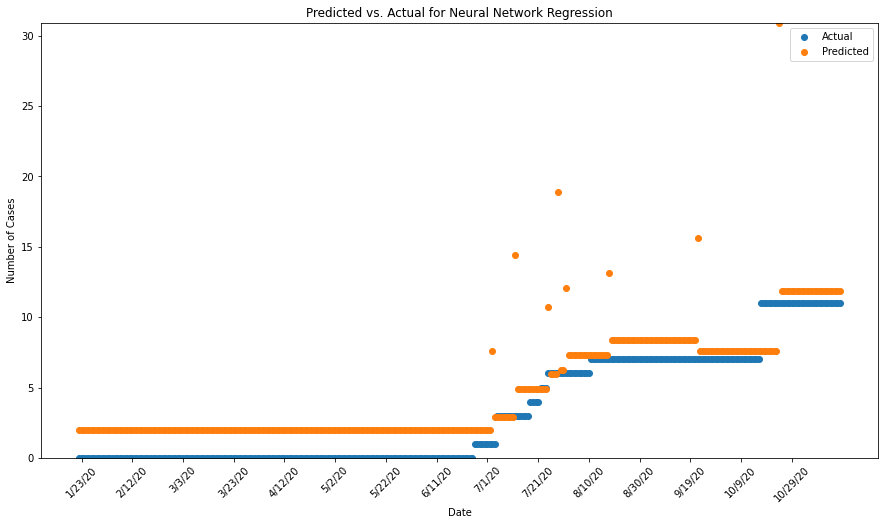

R2 Score: 0.6132569781901995
Weighted Accuracy w/ Threshold of 10.0%: 23.25581395348837%.


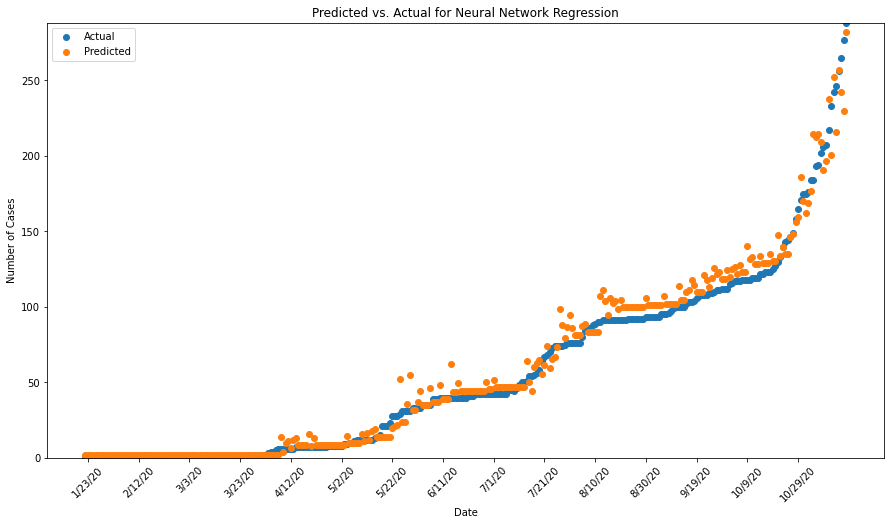

R2 Score: 0.9808424971320026
Weighted Accuracy w/ Threshold of 10.0%: 43.521594684385384%.


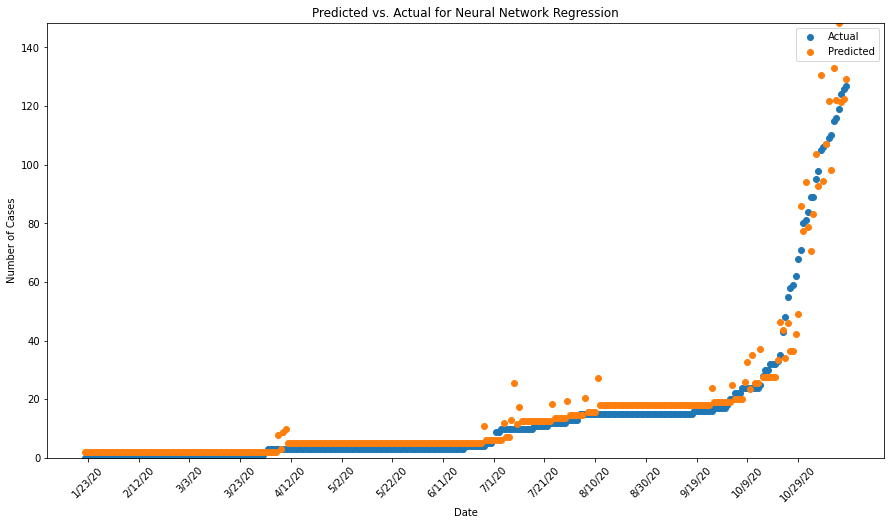

R2 Score: 0.960950117838376
Weighted Accuracy w/ Threshold of 10.0%: 11.295681063122924%.


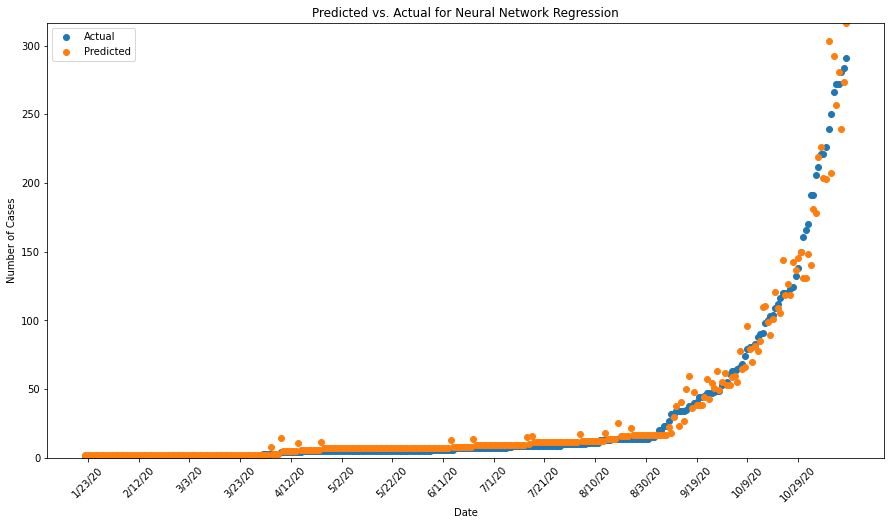

R2 Score: 0.9770165377767883
Weighted Accuracy w/ Threshold of 10.0%: 16.27906976744186%.


In [260]:
for county_idx in range(len(X_test_list)):
    predictions = model_5.predict(X_test_list[county_idx]).flatten()
    graph_predicted_vs_actual_nn(X_test_list[county_idx], Y_test_list[county_idx], predictions)
    
    print('R2 Score: ' + str(r2_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()))))
    accuracy_score(predictions, np.ravel(Y_test_list[county_idx].to_numpy()), 0.1)